In [72]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

In [73]:
data_file = 'C:\Sohail_MS\Algo_Digital_Marketing\Assignment\Assignment 3\Part2\criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

In [108]:
df0

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16468022,2671199,5767906,4869923,0,-1,-1,0,1,-1,-1,...,482560,30763035,26597095,13113052,29196072,5824236,30763035,18391143,29196072,8661623
16468023,2671199,6852682,10002432,0,-1,-1,0,0,-1,-1,...,971748,25259032,9312274,10979162,29196072,32440044,29196072,27259439,29196072,8661620
16468024,2671199,16638720,7061828,0,-1,-1,0,0,-1,-1,...,268431,30763035,5824235,29542751,29196072,5824237,29196072,3696777,29196072,21091111
16468025,2671199,3032300,5061834,0,-1,-1,0,1,-1,-1,...,-1,1973606,26597096,28944164,29196072,26611392,1973606,5642940,14911188,29196072


In [76]:
n_campaigns = 50

In [78]:
def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext
df1 = add_derived_columns(df0)

In [79]:
def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]
df2 = sample_campaigns(df1, n_campaigns)

In [80]:
def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]
df3 = filter_journeys_by_length(df2, 2)

In [81]:
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)
df4 = balance_conversions(df3)

In [82]:
def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [83]:
print(df6.shape[0])

print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

66767
[33670, 33097]


# First Touch Attribution

In [84]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']

    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return (campaign_conversions) / campaign_impressions
    
fta = first_touch_attribution(df6)

33097
true count 10229


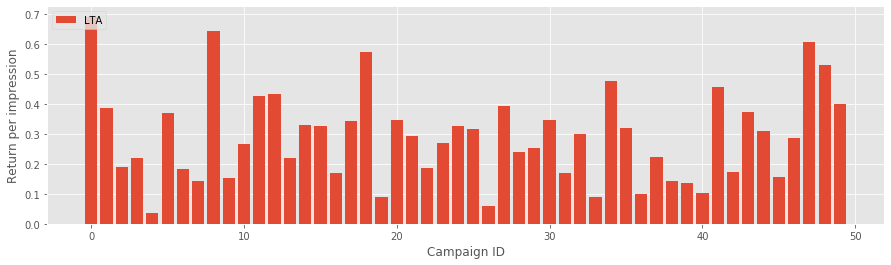

In [85]:
campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Last Touch Attribution

In [86]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']

    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return (campaign_conversions) / campaign_impressions
    
lta = last_touch_attribution(df6)

33097
true count 10229


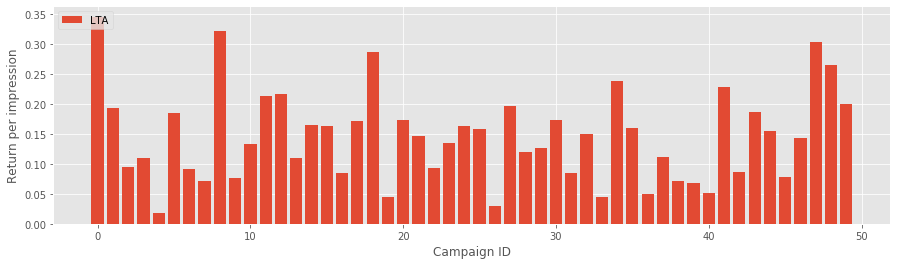

In [87]:
campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Linear Touch Attribution

In [105]:
def linear_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) >= df_converted['timestamp_norm']

    print(idx.count())
    idx_true = idx[idx.values==True]
    print('true count', idx_true.count())
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lita = linear_touch_attribution(df6)

33097
true count 33097


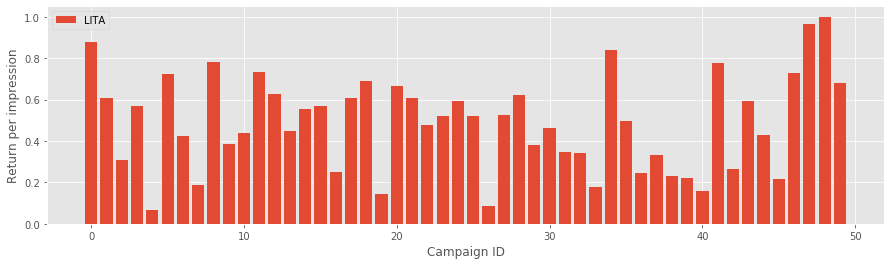

In [106]:
# Visualization of the attribution scores

campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lita[campaign_idx])), lita[campaign_idx], label='LITA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# U Touch Attribution

In [89]:
#
def U_touch_attribution(df):
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    campaign_impressions = count_by_campaign(df)
    
    
    df_converted = df[df['conversion'] == 1]
    temp_jid=0
    campaign_conversions_nrml=0
    campaign_conversions_first=0
    campaign_conversions_last=0
    campaign_conversions_intermediate=0
    for jid in df_converted.jid.unique():
        if jid != temp_jid:
            temp_jid = jid
            print(temp_jid)
            if df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].max() == df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].min():
                idx_nrml = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
                print("Only 1 Record ")
                campaign_conversions_nrml = count_by_campaign(df_converted[idx_nrml])
            if df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].max() != df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].min():
                idx_min = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
                idx_max = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
                print("Multiple Records ")
                campaign_conversions_first = count_by_campaign(df_converted[idx_min])
                campaign_conversions_last = count_by_campaign(df_converted[idx_max])
                campaign_conversions_intermediate = (campaign_impressions - (campaign_conversions_first + campaign_conversions_last ))
    return (((campaign_conversions_nrml + campaign_conversions_first + campaign_conversions_last ) * .7) + (campaign_conversions_intermediate * .3)) / campaign_impressions
uta = U_touch_attribution(df6)

23219147_12094942
Multiple Records 
21801985_11191759
Multiple Records 
6084248_12248600
Multiple Records 
26432465_24174905
Multiple Records 
10981333_30499124
Multiple Records 
29823239_4225593
Multiple Records 
13247849_28950214
Multiple Records 
27296207_18389752
Multiple Records 
30123576_5316574
Multiple Records 
9705860_17078307
Multiple Records 
12914345_6457833
Multiple Records 
19508815_5942214
Multiple Records 
18469039_27233042
Multiple Records 
16320332_10606235
Multiple Records 
26101272_15537854
Multiple Records 
26976522_24156292
Multiple Records 
10348329_21265291
Multiple Records 
5045314_3852287
Multiple Records 
14664263_21705276
Multiple Records 
18584071_3122941
Multiple Records 
4534765_10831774
Multiple Records 
23446997_10506951
Multiple Records 
5609745_15764465
Multiple Records 
26084023_23147577
Multiple Records 
25716544_12545589
Multiple Records 
8980279_31869210
Multiple Records 
23802254_31655752
Multiple Records 
4601969_6228830
Multiple Records 
297946

20390236_14644826
Multiple Records 
22478271_1089295
Multiple Records 
10244641_22252552
Multiple Records 
5951360_7854915
Multiple Records 
5460858_6502600
Multiple Records 
13295535_12953239
Multiple Records 
23253182_2576369
Multiple Records 
11487377_27130473
Multiple Records 
24475496_23529407
Multiple Records 
19943798_13680441
Multiple Records 
2886149_18781527
Multiple Records 
10791584_576688
Multiple Records 
15700276_15920696
Multiple Records 
12561644_19556501
Multiple Records 
5069106_17339266
Multiple Records 
29574906_24856414
Multiple Records 
1960004_20350139
Multiple Records 
16854265_31683074
Multiple Records 
3985930_27994686
Multiple Records 
29176813_28929697
Multiple Records 
23313320_25645842
Multiple Records 
15808539_26817601
Multiple Records 
13881323_30015963
Multiple Records 
16750257_11993913
Multiple Records 
9346806_2419092
Multiple Records 
25059946_22954732
Multiple Records 
8661768_27356010
Multiple Records 
27074986_27978723
Multiple Records 
1745971

30487070_1135150
Multiple Records 
30953083_7803862
Multiple Records 
29271567_7004069
Multiple Records 
18272916_16640145
Multiple Records 
31810609_2988868
Multiple Records 
6781526_11172298
Multiple Records 
11318849_31271102
Multiple Records 
11532108_25982267
Multiple Records 
31704781_7397058
Multiple Records 
25873573_28009714
Multiple Records 
24419700_25240570
Multiple Records 
10402866_23586912
Multiple Records 
13841837_11207093
Multiple Records 
1570982_25008268
Multiple Records 
11377373_28096362
Multiple Records 
7114376_5804927
Multiple Records 
19180404_2619933
Multiple Records 
5639698_30725916
Multiple Records 
19720594_20761750
Multiple Records 
9403662_31351866
Multiple Records 
11139696_22052573
Multiple Records 
9102464_32306046
Multiple Records 
16491411_18069208
Multiple Records 
4607983_26798659
Multiple Records 
9511139_2416461
Multiple Records 
23985824_25252585
Multiple Records 
25604146_19971632
Multiple Records 
28988083_15771256
Multiple Records 
22054160

29005634_17357510
Multiple Records 
1246864_12893778
Multiple Records 
11309142_16796467
Multiple Records 
207713_7051964
Multiple Records 
20952993_22382285
Multiple Records 
6457290_9355798
Multiple Records 
14126704_19920107
Multiple Records 
31669550_32382310
Multiple Records 
10561485_7549849
Multiple Records 
1286592_31913993
Multiple Records 
4222051_21684456
Multiple Records 
114260_18056384
Multiple Records 
7964738_32044404
Multiple Records 
19541801_74383
Multiple Records 
20996209_3940578
Multiple Records 
4442579_9374459
Multiple Records 
23525185_31195762
Multiple Records 
10530173_8000466
Multiple Records 
23598395_20762641
Multiple Records 
3067073_5791458
Multiple Records 
3727507_13425027
Multiple Records 
156368_4389365
Multiple Records 
7938866_19547832
Multiple Records 
30622948_20881321
Multiple Records 
1420825_30384195
Multiple Records 
2627097_17468672
Multiple Records 
10684705_19648446
Multiple Records 
23793621_21679280
Multiple Records 
16673755_19023319
Mu

19386266_20354682
Multiple Records 
27237765_21730637
Multiple Records 
20011036_20528972
Multiple Records 
19572634_25642203
Multiple Records 
14840323_15021128
Multiple Records 
1856690_31578002
Multiple Records 
14350310_19171073
Multiple Records 
16719986_12003913
Multiple Records 
19818277_24146964
Multiple Records 
1132300_4198185
Multiple Records 
4444005_5817720
Multiple Records 
21231928_29524172
Multiple Records 
17203585_1034547
Multiple Records 
7553204_17269251
Multiple Records 
22652768_32063350
Multiple Records 
26654715_10553917
Multiple Records 
11495359_29538224
Multiple Records 
5701896_31926150
Multiple Records 
4579214_30746821
Multiple Records 
19384500_11776369
Multiple Records 
3776421_2253800
Multiple Records 
359790_2167603
Multiple Records 
2496164_19571526
Multiple Records 
27044568_18525884
Multiple Records 
11304983_15515118
Multiple Records 
21801985_2792890
Multiple Records 
30462159_20037685
Multiple Records 
1367372_2148710
Multiple Records 
29704770_9

2565404_28028653
Multiple Records 
3590710_31133867
Multiple Records 
3209455_21096487
Multiple Records 
4132249_8683862
Multiple Records 
18960754_24169173
Multiple Records 
13569818_5460257
Multiple Records 
4220084_30547022
Multiple Records 
23524389_15601893
Multiple Records 
4266217_6795608
Multiple Records 
7257503_3543244
Multiple Records 
1588643_19086820
Multiple Records 
23109803_23591512
Multiple Records 
27531473_19212129
Multiple Records 
14643615_25621614
Multiple Records 
7715183_3869649
Multiple Records 
25834791_14148893
Multiple Records 
6798716_17824037
Multiple Records 
20318072_16856138
Multiple Records 
22559737_23109655
Multiple Records 
12810810_9364310
Multiple Records 
17900646_22440117
Multiple Records 
679807_22644415
Multiple Records 
23799355_4001560
Multiple Records 
15897954_13832035
Multiple Records 
23631148_11713350
Multiple Records 
6489829_9245838
Multiple Records 
30253561_7173958
Multiple Records 
13634242_11348912
Multiple Records 
27838090_25005

15788793_28155344
Multiple Records 
13211734_28298395
Multiple Records 
30116551_30604189
Multiple Records 
19775927_24793522
Multiple Records 
31206103_18453485
Multiple Records 
22649131_23818396
Multiple Records 
11601295_8721014
Multiple Records 
12727703_26633133
Multiple Records 
19314567_2091756
Multiple Records 
29506497_26489749
Multiple Records 
15487521_27742982
Multiple Records 
10494954_22639443
Multiple Records 
25192153_3183044
Multiple Records 
2395104_26060159
Multiple Records 
10946467_22769501
Multiple Records 
8762079_21028254
Multiple Records 
1054508_12418275
Multiple Records 
16773357_15335954
Multiple Records 
16535316_16428166
Multiple Records 
12624691_26298537
Multiple Records 
28906699_11996019
Multiple Records 
23218772_24210749
Multiple Records 
24044070_24378696
Multiple Records 
20057405_17698822
Multiple Records 
13703633_13823974
Multiple Records 
17826488_22742836
Multiple Records 
3983089_17473183
Multiple Records 
15589764_5653253
Multiple Records 


11345478_23437260
Multiple Records 
19861763_2954199
Multiple Records 
5223374_10632641
Multiple Records 
15781731_21959028
Multiple Records 
19618971_4052185
Multiple Records 
5841317_24627077
Multiple Records 
18633785_29073990
Multiple Records 
8430062_31682281
Multiple Records 
14762530_18945296
Multiple Records 
30393625_28050215
Multiple Records 
23434951_29526833
Multiple Records 
18345319_21674845
Multiple Records 
10202389_28692531
Multiple Records 
25190980_22131112
Multiple Records 
25172546_28674991
Multiple Records 
9830443_13437677
Multiple Records 
23675033_23078560
Multiple Records 
22061939_1876829
Multiple Records 
17808476_19167824
Multiple Records 
20125547_337096
Multiple Records 
19204249_15297606
Multiple Records 
1316421_4954862
Multiple Records 
8998645_19497280
Multiple Records 
9038551_14860011
Multiple Records 
18583336_14520970
Multiple Records 
4719874_31297386
Multiple Records 
32176974_25341184
Multiple Records 
13372293_11841440
Multiple Records 
926031

19974533_26624564
Multiple Records 
17405890_1331315
Multiple Records 
14739764_23288866
Multiple Records 
18597362_26947803
Multiple Records 
28165380_30831406
Multiple Records 
14330039_22721606
Multiple Records 
18355986_14940434
Multiple Records 
15129600_17504426
Multiple Records 
27019157_22354518
Multiple Records 
2553601_5209556
Multiple Records 
11079536_19759444
Multiple Records 
1901361_29330012
Multiple Records 
9070887_26446029
Multiple Records 
7130821_16754751
Multiple Records 
9710229_23463677
Multiple Records 
20467219_24886052
Multiple Records 
14146489_4732398
Multiple Records 
22703310_5019322
Multiple Records 
3306119_13050262
Multiple Records 
7175384_21983943
Multiple Records 
3753382_6828959
Multiple Records 
15910724_32040955
Multiple Records 
7248695_5388076
Multiple Records 
5477420_22043023
Multiple Records 
5624571_7445713
Multiple Records 
24268986_19484378
Multiple Records 
12560185_18072503
Multiple Records 
3128582_2107482
Multiple Records 
29254952_134

8619433_24004288
Multiple Records 
23449638_10674001
Multiple Records 
21494990_23726742
Multiple Records 
7692192_6056333
Multiple Records 
17235101_4415367
Multiple Records 
12967967_2385088
Multiple Records 
25742875_17241476
Multiple Records 
7539747_540718
Multiple Records 
7520836_22455442
Multiple Records 
31069286_30082011
Multiple Records 
4273176_29081322
Multiple Records 
24646235_263667
Multiple Records 
7932590_11897927
Multiple Records 
9996030_5727508
Multiple Records 
29588761_25674984
Multiple Records 
22766407_3401872
Multiple Records 
15820094_7103479
Multiple Records 
30014849_30959909
Multiple Records 
19475638_15002058
Multiple Records 
6012703_13539628
Multiple Records 
10614144_27357267
Multiple Records 
1798691_18638640
Multiple Records 
29986123_9101854
Multiple Records 
20701843_28282707
Multiple Records 
22062416_27769548
Multiple Records 
183137_20035953
Multiple Records 
17447311_511929
Multiple Records 
20100074_18937043
Multiple Records 
23565570_2433981

2881433_12530577
Multiple Records 
31587001_984306
Multiple Records 
25178223_21199062
Multiple Records 
8637880_6217858
Multiple Records 
4935657_31427692
Multiple Records 
5750189_18472133
Multiple Records 
1288443_1438912
Multiple Records 
4520401_6461994
Multiple Records 
5555230_1364991
Multiple Records 
20068129_14000746
Multiple Records 
5554_15935224
Multiple Records 
1999582_13702249
Multiple Records 
2698108_13300519
Multiple Records 
12109237_30616472
Multiple Records 
4702217_25201203
Multiple Records 
1725993_28011537
Multiple Records 
21128617_32414780
Multiple Records 
13455649_25702197
Multiple Records 
17691430_30623698
Multiple Records 
27060256_30448481
Multiple Records 
26670790_18433271
Multiple Records 
2889092_11204384
Multiple Records 
1313076_29397966
Multiple Records 
6700681_5148351
Multiple Records 
11382181_10223128
Multiple Records 
23434951_11207706
Multiple Records 
23521330_20148914
Multiple Records 
7122995_11861016
Multiple Records 
5637791_3026958
Mu

29951035_19328413
Multiple Records 
2998164_15041555
Multiple Records 
3215652_114832
Multiple Records 
22118342_16709135
Multiple Records 
5317631_16655769
Multiple Records 
32133226_23234681
Multiple Records 
7861041_31027238
Multiple Records 
5529619_31156745
Multiple Records 
5069106_18257586
Multiple Records 
4692891_14390628
Multiple Records 
24878136_30001087
Multiple Records 
2766484_22254006
Multiple Records 
19087809_31897220
Multiple Records 
18860581_14074655
Multiple Records 
2631935_21572969
Multiple Records 
15115787_4249972
Multiple Records 
1780236_922576
Multiple Records 
14697822_30087101
Multiple Records 
20656749_23410960
Multiple Records 
31396938_29256721
Multiple Records 
286123_21535747
Multiple Records 
11297140_124564
Multiple Records 
14792072_24097243
Multiple Records 
23596546_21367087
Multiple Records 
23843884_25966642
Multiple Records 
10301742_16786071
Multiple Records 
17252722_12620081
Multiple Records 
500952_22004396
Multiple Records 
5699648_31003

27933958_8251127
Multiple Records 
15136786_6515634
Multiple Records 
20369012_32164012
Multiple Records 
31383281_11607739
Multiple Records 
9795583_5604070
Multiple Records 
20800621_18495397
Multiple Records 
10018020_17426035
Multiple Records 
11290465_27025695
Multiple Records 
30847064_10088974
Multiple Records 
22622740_20301785
Multiple Records 
225540_682985
Multiple Records 
25701078_10384481
Multiple Records 
18070111_16123587
Multiple Records 
29606742_7222883
Multiple Records 
18361978_30494989
Multiple Records 
9720454_24325083
Multiple Records 
19737261_9633732
Multiple Records 
22566660_14061415
Multiple Records 
10149871_27912768
Multiple Records 
26083833_6414422
Multiple Records 
27662363_17282093
Multiple Records 
30154956_4862517
Multiple Records 
27907555_31992574
Multiple Records 
15574393_26631559
Multiple Records 
19894747_9839060
Multiple Records 
25987065_28432636
Multiple Records 
1577203_9460078
Multiple Records 
19692647_2127216
Multiple Records 
1331235_3

Multiple Records 
20974616_17296878
Multiple Records 
24181517_9272998
Multiple Records 
31210778_24975107
Multiple Records 
29302341_26043590
Multiple Records 
12604591_12850768
Multiple Records 
26378172_14677503
Multiple Records 
23449638_16397927
Multiple Records 
121024_14030637
Multiple Records 
20307880_24541581
Multiple Records 
14790011_18283044
Multiple Records 
8290514_6289141
Multiple Records 
14680556_26114966
Multiple Records 
6690338_26333310
Multiple Records 
25039184_27634879
Multiple Records 
26678819_29492286
Multiple Records 
25043320_12194305
Multiple Records 
1043562_4749065
Multiple Records 
28300703_11838423
Multiple Records 
1022476_24114336
Multiple Records 
25964155_11630453
Multiple Records 
6019655_18248760
Multiple Records 
18097866_22785856
Multiple Records 
14096306_11088695
Multiple Records 
6695501_15867429
Multiple Records 
16815171_14030303
Multiple Records 
10265944_4528565
Multiple Records 
5915418_24091800
Multiple Records 
6517409_27824627
Multip

31826022_27934712
Multiple Records 
24925564_24387776
Multiple Records 
6313820_5053607
Multiple Records 
19219404_610343
Multiple Records 
26353123_20598573
Multiple Records 
18372826_9633893
Multiple Records 
3892838_15506363
Multiple Records 
31730268_29478451
Multiple Records 
17055524_7475168
Multiple Records 
19039628_20529033
Multiple Records 
17707829_30501691
Multiple Records 
19884369_30919160
Multiple Records 
16442726_10808667
Multiple Records 
10322613_31062918
Multiple Records 
10219207_7624950
Multiple Records 
145437_30140870
Multiple Records 
30465069_17803025
Multiple Records 
21955591_16934634
Multiple Records 
12406460_18519792
Multiple Records 
7854376_6924125
Multiple Records 
29702862_16553522
Multiple Records 
4286900_22534743
Multiple Records 
5623468_11849542
Multiple Records 
8661050_11322032
Multiple Records 
12855105_22348219
Multiple Records 
16375190_2640538
Multiple Records 
13140925_26424056
Multiple Records 
12514860_3775692
Multiple Records 
27984523_

Multiple Records 
6390290_9732962
Multiple Records 
1401159_20276414
Multiple Records 
14875463_21459925
Multiple Records 
2609983_5640616
Multiple Records 
18798558_11052475
Multiple Records 
10250734_21611909
Multiple Records 
2748635_19498588
Multiple Records 
10449876_2917688
Multiple Records 
6179492_2916999
Multiple Records 
8444627_31684698
Multiple Records 
6395312_9962789
Multiple Records 
31917311_24975406
Multiple Records 
13006443_25286147
Multiple Records 
25382143_191999
Multiple Records 
26737869_11148858
Multiple Records 
23140076_26314874
Multiple Records 
7904368_1503806
Multiple Records 
16815603_4789780
Multiple Records 
29542997_21003340
Multiple Records 
6026446_24143618
Multiple Records 
17203881_27452816
Multiple Records 
6242966_8278889
Multiple Records 
17270741_19053230
Multiple Records 
4510360_20485633
Multiple Records 
8290065_26723553
Multiple Records 
1008435_28949372
Multiple Records 
24740773_18100319
Multiple Records 
29972996_4530155
Multiple Records

29347609_16077568
Multiple Records 
8851936_25955548
Multiple Records 
26637855_5648626
Multiple Records 
17502917_21450954
Multiple Records 
17938837_10618552
Multiple Records 
6626667_16403993
Multiple Records 
9512697_14219556
Multiple Records 
12727175_9575679
Multiple Records 
14191234_9831928
Multiple Records 
25952209_22888356
Multiple Records 
9718664_2137492
Multiple Records 
3516905_17563079
Multiple Records 
29223411_6813986
Multiple Records 
9695802_19341186
Multiple Records 
76000_27159781
Multiple Records 
27459843_15606901
Multiple Records 
23505627_31538691
Multiple Records 
15754222_14331706
Multiple Records 
32339479_725127
Multiple Records 
2547093_15719937
Multiple Records 
30868712_7422585
Multiple Records 
24862429_31106251
Multiple Records 
5070696_20209258
Multiple Records 
6247231_11030207
Multiple Records 
26884209_1226617
Multiple Records 
13949964_17066465
Multiple Records 
26322915_12258053
Multiple Records 
353323_18441302
Multiple Records 
1842129_2101904

16338169_2982295
Multiple Records 
163422_11482358
Multiple Records 
27701629_24244338
Multiple Records 
24745063_31971492
Multiple Records 
10926673_20603734
Multiple Records 
16451220_5475265
Multiple Records 
15163858_30987476
Multiple Records 
13651603_2631964
Multiple Records 
16264974_2364651
Multiple Records 
2815084_27004107
Multiple Records 
23819379_5568080
Multiple Records 
8391037_23773377
Multiple Records 
8537023_7371842
Multiple Records 
15163858_242192
Multiple Records 
2949279_24343876
Multiple Records 
2450141_26065428
Multiple Records 
28342654_24042441
Multiple Records 
28003048_5992697
Multiple Records 
4406658_134688
Multiple Records 
28239357_4086230
Multiple Records 
7450896_6134077
Multiple Records 
31317415_21132359
Multiple Records 
22529453_9134826
Multiple Records 
5427535_2557348
Multiple Records 
19274866_22908495
Multiple Records 
9704784_27939885
Multiple Records 
21747893_31029552
Multiple Records 
5516685_8334874
Multiple Records 
5140237_6074150
Mult

17395729_29853418
Multiple Records 
26444129_29079150
Multiple Records 
17184933_17831445
Multiple Records 
10121805_23735213
Multiple Records 
24370767_5931605
Multiple Records 
31998716_27884143
Multiple Records 
32350114_24167616
Multiple Records 
10369678_19383195
Multiple Records 
2450235_10709474
Multiple Records 
29721614_19021744
Multiple Records 
12332152_7794551
Multiple Records 
17624855_11336233
Multiple Records 
17918801_7641147
Multiple Records 
9490353_12109042
Multiple Records 
21780196_12287153
Multiple Records 
21919361_26376640
Multiple Records 
29736364_8003787
Multiple Records 
12041450_14659934
Multiple Records 
11472904_23861365
Multiple Records 
23934585_13571589
Multiple Records 
4186114_6037175
Multiple Records 
5574719_18616154
Multiple Records 
13949698_22357379
Multiple Records 
12998367_26240378
Multiple Records 
17635949_1672142
Multiple Records 
5224379_5770415
Multiple Records 
16910799_7178278
Multiple Records 
30503102_30682617
Multiple Records 
68145

Multiple Records 
31904270_16090708
Multiple Records 
11485056_18698312
Multiple Records 
13651603_7507915
Multiple Records 
9668851_12332809
Multiple Records 
26719982_15713336
Multiple Records 
1897212_13176673
Multiple Records 
30426872_32273360
Multiple Records 
17776626_723110
Multiple Records 
12394600_8793692
Multiple Records 
2957354_15546135
Multiple Records 
20433293_32188627
Multiple Records 
22767728_17997563
Multiple Records 
28325403_32407280
Multiple Records 
18269505_20893584
Multiple Records 
30337596_19718189
Multiple Records 
23342847_26915304
Multiple Records 
4923736_24196909
Multiple Records 
7174133_29370993
Multiple Records 
1804978_4223738
Multiple Records 
9590323_27850505
Multiple Records 
29381399_23440723
Multiple Records 
13020014_16569974
Multiple Records 
2049202_18783999
Multiple Records 
12847211_30184505
Multiple Records 
7342857_6960470
Multiple Records 
24688129_21292754
Multiple Records 
20268497_6109702
Multiple Records 
3169356_21849942
Multiple 

17785954_24778605
Multiple Records 
4832804_15635851
Multiple Records 
18985083_24039152
Multiple Records 
11098204_19953910
Multiple Records 
7353744_21967849
Multiple Records 
5119247_23616975
Multiple Records 
7688575_10296951
Multiple Records 
9884141_2320805
Multiple Records 
12561459_21254699
Multiple Records 
6117638_30719885
Multiple Records 
676637_13140917
Multiple Records 
30522868_4388947
Multiple Records 
3333255_7307684
Multiple Records 
23069815_9325324
Multiple Records 
17827906_4341145
Multiple Records 
25067692_26998581
Multiple Records 
16153380_29472283
Multiple Records 
25912310_745341
Multiple Records 
14146489_8669713
Multiple Records 
24148066_15688439
Multiple Records 
24702057_25239114
Multiple Records 
14323845_9227389
Multiple Records 
3326082_2512857
Multiple Records 
19128428_10990180
Multiple Records 
10193206_17785158
Multiple Records 
18567284_25114400
Multiple Records 
21579236_15162828
Multiple Records 
22938946_8157669
Multiple Records 
27358842_1365

18223065_5569648
Multiple Records 
16563398_2783393
Multiple Records 
15863128_27201404
Multiple Records 
13959193_8500725
Multiple Records 
2947480_20520869
Multiple Records 
132322_23393850
Multiple Records 
7819177_22641088
Multiple Records 
27531473_14743143
Multiple Records 
6345077_12742843
Multiple Records 
10590760_26977898
Multiple Records 
25705329_22709628
Multiple Records 
1870717_17363692
Multiple Records 
13211734_1383763
Multiple Records 
17861700_17914704
Multiple Records 
24333515_7527295
Multiple Records 
3423961_1895749
Multiple Records 
15279738_27089235
Multiple Records 
30839923_3011384
Multiple Records 
29391680_1044980
Multiple Records 
30966599_25087145
Multiple Records 
8570648_17285467
Multiple Records 
6517317_9904172
Multiple Records 
18971899_31133626
Multiple Records 
22635229_12351425
Multiple Records 
12499382_32275716
Multiple Records 
14959516_29834155
Multiple Records 
10096951_412599
Multiple Records 
3720203_13786961
Multiple Records 
4021401_28464

Multiple Records 
27353962_14091451
Multiple Records 
21879990_14021671
Multiple Records 
8269686_25722816
Multiple Records 
8756022_6556768
Multiple Records 
7848910_17216872
Multiple Records 
13932010_14670674
Multiple Records 
17785543_22379249
Multiple Records 
10178518_31957720
Multiple Records 
8527494_18936076
Multiple Records 
32442952_16781453
Multiple Records 
26530548_23165643
Multiple Records 
20663946_19407103
Multiple Records 
29884441_15334447
Multiple Records 
30628760_17072449
Multiple Records 
31858497_7394584
Multiple Records 
1289602_20876152
Multiple Records 
13196252_12817848
Multiple Records 
6399054_30325688
Multiple Records 
15711577_30321514
Multiple Records 
20123836_13068976
Multiple Records 
21199429_7489622
Multiple Records 
23141357_31191455
Multiple Records 
20173338_25662955
Multiple Records 
20300454_15781421
Multiple Records 
20648976_29228490
Multiple Records 
3941243_6050110
Multiple Records 
30893455_14078234
Multiple Records 
23496483_4093140
Mult

3958964_7256545
Multiple Records 
23141845_30744911
Multiple Records 
896069_23285691
Multiple Records 
23380390_6045738
Multiple Records 
18044671_20324281
Multiple Records 
5025733_20416154
Multiple Records 
8755343_32011959
Multiple Records 
1938619_18515563
Multiple Records 
9547388_30097953
Multiple Records 
9824339_23532111
Multiple Records 
24021660_24871310
Multiple Records 
17060628_23342806
Multiple Records 
20930176_16757195
Multiple Records 
6598396_32336141
Multiple Records 
11224941_14836536
Multiple Records 
16221915_5861640
Multiple Records 
29835168_8845085
Multiple Records 
12187746_21077480
Multiple Records 
3221760_2395325
Multiple Records 
3393873_13599671
Multiple Records 
26208917_20365857
Multiple Records 
32321163_22020929
Multiple Records 
27942136_18920503
Multiple Records 
6280564_1425884
Multiple Records 
24042373_27421732
Multiple Records 
19584672_32229525
Multiple Records 
5168463_25814804
Multiple Records 
24476142_26267548
Multiple Records 
23531974_29

Multiple Records 
13508822_25650624
Multiple Records 
12168628_13996783
Multiple Records 
4847335_19587016
Multiple Records 
11012651_19944235
Multiple Records 
30300409_31990820
Multiple Records 
21758248_17457559
Multiple Records 
17178948_11586962
Multiple Records 
3232699_6474631
Multiple Records 
9769673_24532333
Multiple Records 
28584874_26914321
Multiple Records 
18272725_2088608
Multiple Records 
29506534_18882300
Multiple Records 
3078151_20471645
Multiple Records 
19688311_16684540
Multiple Records 
26404391_28399955
Multiple Records 
8805799_26521342
Multiple Records 
27052471_11681024
Multiple Records 
7716635_14252456
Multiple Records 
4070093_12467261
Multiple Records 
19943794_19457535
Multiple Records 
5453639_132676
Multiple Records 
1912501_9348385
Multiple Records 
5699356_19402236
Multiple Records 
6891678_17071672
Multiple Records 
30361142_29072691
Multiple Records 
6870328_21236736
Multiple Records 
10646658_14991886
Multiple Records 
12298615_24961613
Multiple 

14216479_934082
Multiple Records 
10294996_1847482
Multiple Records 
8796293_8244884
Multiple Records 
20591554_28739268
Multiple Records 
22954649_9800350
Multiple Records 
28610567_361863
Multiple Records 
6225840_2719257
Multiple Records 
20975002_20507135
Multiple Records 
1109009_25442566
Multiple Records 
1656934_20039264
Multiple Records 
24352283_2700610
Multiple Records 
5983053_15338468
Multiple Records 
24812932_22265922
Multiple Records 
351747_8099568
Multiple Records 
14057000_18635631
Multiple Records 
30189394_13747232
Multiple Records 
8498787_16585954
Multiple Records 
22963345_1014733
Multiple Records 
3899893_5960501
Multiple Records 
25106011_3002038
Multiple Records 
25981400_15258696
Multiple Records 
23156199_24052123
Multiple Records 
7952423_12256682
Multiple Records 
20019831_26585184
Multiple Records 
20967305_9232060
Multiple Records 
10810391_22193865
Multiple Records 
7913094_19764079
Multiple Records 
11877674_2670484
Multiple Records 
13454368_20138231


Multiple Records 
28714278_6837976
Multiple Records 
6418471_13018312
Multiple Records 
4277780_14290936
Multiple Records 
21705297_19635387
Multiple Records 
1082212_16268014
Multiple Records 
20007348_9973061
Multiple Records 
29708690_539422
Multiple Records 
31486809_8716685
Multiple Records 
30945571_15110690
Multiple Records 
4552508_4026139
Multiple Records 
1073493_15416162
Multiple Records 
5351210_2888754
Multiple Records 
17362866_31848667
Multiple Records 
21836907_16435235
Multiple Records 
7736710_16872044
Multiple Records 
484762_12669290
Multiple Records 
4272318_16685097
Multiple Records 
28653783_11900674
Multiple Records 
2423824_11720519
Multiple Records 
22755616_10110437
Multiple Records 
19509140_4039377
Multiple Records 
20211331_29768690
Multiple Records 
15461650_22776346
Multiple Records 
30441969_3881047
Multiple Records 
25877900_6474961
Multiple Records 
14265575_11451537
Multiple Records 
11355276_26332587
Multiple Records 
4821108_1389114
Multiple Record

19596804_8032923
Multiple Records 
11306498_23502033
Multiple Records 
29153934_6395810
Multiple Records 
19508818_4787532
Multiple Records 
9747010_12912432
Multiple Records 
12410647_10851726
Multiple Records 
4192984_29802291
Multiple Records 
10150947_6541519
Multiple Records 
23345266_7558723
Multiple Records 
7237211_4045559
Multiple Records 
1190258_18475225
Multiple Records 
3240960_17256202
Multiple Records 
2113793_16238036
Multiple Records 
3973601_13761102
Multiple Records 
16933887_15212871
Multiple Records 
21995623_6899716
Multiple Records 
19463123_27227799
Multiple Records 
2196835_17812342
Multiple Records 
9690764_26136216
Multiple Records 
3288560_9745237
Multiple Records 
29481564_14242262
Multiple Records 
24761539_3738067
Multiple Records 
9434362_20537638
Multiple Records 
9502692_18327023
Multiple Records 
13797770_12054501
Multiple Records 
5671692_23562254
Multiple Records 
10178922_12753823
Multiple Records 
20049128_1713722
Multiple Records 
12991136_543333

31887100_5339725
Multiple Records 
23783109_11321236
Multiple Records 
12137783_9151774
Multiple Records 
16016610_1590392
Multiple Records 
14798523_3897442
Multiple Records 
25424122_24799915
Multiple Records 
10063041_372474
Multiple Records 
31569601_30835439
Multiple Records 
24846795_4820804
Multiple Records 
1952663_31892733
Multiple Records 
8696351_75308
Multiple Records 
30726289_26239727
Multiple Records 
15754222_32010774
Multiple Records 
18553401_10099813
Multiple Records 
336598_31179934
Multiple Records 
23947902_27982767
Multiple Records 
10735119_4104247
Multiple Records 
15668187_758039
Multiple Records 
4410525_31446062
Multiple Records 
20585997_25429802
Multiple Records 
6258687_27380733
Multiple Records 
26365_10260927
Multiple Records 
29203240_2714191
Multiple Records 
30048982_20275559
Multiple Records 
9709857_25577860
Multiple Records 
5649700_12241796
Multiple Records 
10419277_8811008
Multiple Records 
21633715_13545783
Multiple Records 
21599336_10977335


30682461_23508350
Multiple Records 
22138200_28921528
Multiple Records 
21965020_28036284
Multiple Records 
9161538_21397587
Multiple Records 
9602265_11397382
Multiple Records 
4042786_20801850
Multiple Records 
19706014_17602937
Multiple Records 
11988567_16613019
Multiple Records 
7709331_7618383
Multiple Records 
16818867_9043534
Multiple Records 
1720772_9996629
Multiple Records 
8629011_29133829
Multiple Records 
7370763_23665314
Multiple Records 
10590811_9974257
Multiple Records 
19861763_5716498
Multiple Records 
19335146_3624702
Multiple Records 
2846638_23146198
Multiple Records 
7854859_31977681
Multiple Records 
32025253_488679
Multiple Records 
9968201_8725736
Multiple Records 
3274908_17230059
Multiple Records 
30444319_18018286
Multiple Records 
10168403_19263649
Multiple Records 
2180816_21226639
Multiple Records 
28383525_22006623
Multiple Records 
6316221_8906032
Multiple Records 
14512181_3055455
Multiple Records 
27359221_8884815
Multiple Records 
32223874_7973219


Multiple Records 
5665814_32263840
Multiple Records 
29586926_21731158
Multiple Records 
13315980_30235401
Multiple Records 
14068932_8890391
Multiple Records 
8046050_25604352
Multiple Records 
6995324_17185613
Multiple Records 
19553804_26530940
Multiple Records 
29734646_22441759
Multiple Records 
26850468_16939846
Multiple Records 
14840323_18427237
Multiple Records 
17619750_22663663
Multiple Records 
14294365_30110355
Multiple Records 
28790018_8509922
Multiple Records 
17941371_1979191
Multiple Records 
13044093_14377507
Multiple Records 
10188212_4965367
Multiple Records 
2656520_19952037
Multiple Records 
18634246_11018240
Multiple Records 
5662870_6615631
Multiple Records 
8649396_7860790
Multiple Records 
21273233_5785751
Multiple Records 
30809508_15560145
Multiple Records 
14208576_11107154
Multiple Records 
25197257_10631426
Multiple Records 
31714354_32288271
Multiple Records 
8073450_20863307
Multiple Records 
2957008_30684967
Multiple Records 
19363691_9151454
Multiple

16149115_31321226
Multiple Records 
32302547_9214997
Multiple Records 
26358712_5483417
Multiple Records 
216558_17192752
Multiple Records 
509919_16602287
Multiple Records 
5590863_24583671
Multiple Records 
24473347_12232391
Multiple Records 
16820785_1183579
Multiple Records 
9628700_23400837
Multiple Records 
6478505_27841497
Multiple Records 
13525868_16408107
Multiple Records 
14335635_15007097
Multiple Records 
27897827_7601846
Multiple Records 
15464631_20369342
Multiple Records 
19329715_27153009
Multiple Records 
6939320_31711997
Multiple Records 
19848533_21917019
Multiple Records 
2427477_10864585
Multiple Records 
21578484_31143435
Multiple Records 
20237329_6886909
Multiple Records 
22476514_22215962
Multiple Records 
20075585_27688792
Multiple Records 
15937456_6138060
Multiple Records 
2914190_16311187
Multiple Records 
16615253_20732063
Multiple Records 
17613614_9737243
Multiple Records 
5055319_2935403
Multiple Records 
14085040_22665671
Multiple Records 
24371423_27

Multiple Records 
3559547_8324209
Multiple Records 
21614664_30036747
Multiple Records 
9097294_9375486
Multiple Records 
28948082_5178381
Multiple Records 
4864324_1068722
Multiple Records 
2293265_23830023
Multiple Records 
14500628_29662407
Multiple Records 
10590811_8535620
Multiple Records 
25438596_7063460
Multiple Records 
244240_22043398
Multiple Records 
11044177_21830929
Multiple Records 
22899006_23454248
Multiple Records 
23529631_22866595
Multiple Records 
26254715_13731833
Multiple Records 
18481714_2531660
Multiple Records 
1712453_27927600
Multiple Records 
16859127_19121273
Multiple Records 
13651603_13161025
Multiple Records 
10329864_7487902
Multiple Records 
10278423_5824810
Multiple Records 
24840047_26022901
Multiple Records 
18198143_18958411
Multiple Records 
8661325_10128286
Multiple Records 
735035_4256021
Multiple Records 
19251099_16258553
Multiple Records 
9171835_20797653
Multiple Records 
11480099_15113958
Multiple Records 
25384317_27014254
Multiple Reco

2159200_20717119
Multiple Records 
25290159_1205142
Multiple Records 
14041329_29200360
Multiple Records 
22968257_20964805
Multiple Records 
15279738_3503616
Multiple Records 
23984993_4660788
Multiple Records 
23337435_31017865
Multiple Records 
19704777_9370643
Multiple Records 
17145560_19400990
Multiple Records 
1538881_10000254
Multiple Records 
13478708_17344809
Multiple Records 
13121106_16749404
Multiple Records 
7041135_1026163
Multiple Records 
8472964_30310659
Multiple Records 
17512519_15462679
Multiple Records 
18192616_898258
Multiple Records 
27306913_32013997
Multiple Records 
22162674_17012245
Multiple Records 
27011837_23751104
Multiple Records 
30520458_5162464
Multiple Records 
16331326_8602223
Multiple Records 
20136857_21377306
Multiple Records 
20539787_3528966
Multiple Records 
16116267_17156331
Multiple Records 
10533655_27675623
Multiple Records 
17118548_17334269
Multiple Records 
3203913_7479187
Multiple Records 
25574075_677709
Multiple Records 
15374078_1

1077552_10967307
Multiple Records 
23348873_15705746
Multiple Records 
4595553_6403675
Multiple Records 
12022751_22751465
Multiple Records 
4769254_32030309
Multiple Records 
22633636_26167309
Multiple Records 
28376259_15968143
Multiple Records 
20360603_14519149
Multiple Records 
9227227_939396
Multiple Records 
32448176_17186312
Multiple Records 
6883390_1899332
Multiple Records 
27283294_27162197
Multiple Records 
26630185_25882229
Multiple Records 
21584816_7789584
Multiple Records 
15965018_23672408
Multiple Records 
16793955_12251186
Multiple Records 
28930564_7103739
Multiple Records 
8212078_12459192
Multiple Records 
10779165_32458060
Multiple Records 
22655676_7967498
Multiple Records 
2672727_7408814
Multiple Records 
7261649_20403779
Multiple Records 
6123218_8857563
Multiple Records 
4937308_13028670
Multiple Records 
15927445_27391250
Multiple Records 
6126067_11046653
Multiple Records 
19720400_20226028
Multiple Records 
23567106_2384848
Multiple Records 
30165937_2513

20261378_29612103
Multiple Records 
27361914_1616820
Multiple Records 
484762_11487819
Multiple Records 
6875485_30186393
Multiple Records 
9995702_27589818
Multiple Records 
20991439_1491469
Multiple Records 
25888213_32334794
Multiple Records 
17762962_23628894
Multiple Records 
3982238_1912152
Multiple Records 
12450082_23203241
Multiple Records 
17848788_19634593
Multiple Records 
28910521_2962567
Multiple Records 
6406059_24615549
Multiple Records 
13972726_7785293
Multiple Records 
4192984_24975479
Multiple Records 
5428327_29749011
Multiple Records 
29174018_18709857
Multiple Records 
30370336_17657830
Multiple Records 
28046510_8952036
Multiple Records 
24742345_6036904
Multiple Records 
11927563_20880664
Multiple Records 
15024449_13730704
Multiple Records 
1907099_11300892
Multiple Records 
15986811_27451471
Multiple Records 
24635893_29797094
Multiple Records 
22583770_8933516
Multiple Records 
29797086_14224244
Multiple Records 
10843056_28381211
Multiple Records 
13759126_

Multiple Records 
30376552_21561324
Multiple Records 
5710989_12846304
Multiple Records 
15332425_23994557
Multiple Records 
7550137_13471302
Multiple Records 
11828786_5590505
Multiple Records 
13116710_31890406
Multiple Records 
7885685_3862192
Multiple Records 
6244350_30987796
Multiple Records 
23101924_21220377
Multiple Records 
20494559_2644918
Multiple Records 
28871209_30069710
Multiple Records 
14249421_14137552
Multiple Records 
1719437_16919026
Multiple Records 
21951064_17388756
Multiple Records 
25799448_14925141
Multiple Records 
1917470_7541221
Multiple Records 
14884187_25038357
Multiple Records 
28697112_5115440
Multiple Records 
29562695_12725738
Multiple Records 
30918812_2428682
Multiple Records 
23219730_527133
Multiple Records 
22500897_28552964
Multiple Records 
1053445_28934604
Multiple Records 
14922392_17197544
Multiple Records 
5691767_22510867
Multiple Records 
30977177_10326090
Multiple Records 
8952963_641299
Multiple Records 
1129398_7484556
Multiple Reco

Multiple Records 
7059579_6728216
Multiple Records 
20092921_4302281
Multiple Records 
18056404_10187602
Multiple Records 
12373045_11392427
Multiple Records 
29299090_9082610
Multiple Records 
15080444_3809138
Multiple Records 
10163546_15298973
Multiple Records 
15270968_11783508
Multiple Records 
32315902_6718855
Multiple Records 
2820268_20650041
Multiple Records 
7061244_215465
Multiple Records 
20845457_12727799
Multiple Records 
24567575_7259900
Multiple Records 
8034988_20882692
Multiple Records 
12205035_14206967
Multiple Records 
21021045_12669780
Multiple Records 
26592854_8424850
Multiple Records 
26056205_18684656
Multiple Records 
10753201_21231373
Multiple Records 
10132320_17030106
Multiple Records 
22581095_4372335
Multiple Records 
21753728_15189266
Multiple Records 
12422796_5898136
Multiple Records 
17940664_12430933
Multiple Records 
29037086_6065592
Multiple Records 
20049128_16528646
Multiple Records 
5394497_13050219
Multiple Records 
10959206_6188272
Multiple R

16802697_24453898
Multiple Records 
28985331_26833212
Multiple Records 
28864081_18726179
Multiple Records 
10792753_16195935
Multiple Records 
7798846_14706725
Multiple Records 
29208848_3602712
Multiple Records 
4705969_12788127
Multiple Records 
27970870_26847108
Multiple Records 
14003041_3499801
Multiple Records 
21957446_28760998
Multiple Records 
22644849_16577748
Multiple Records 
26467540_3238332
Multiple Records 
28614170_2729978
Multiple Records 
1855837_788174
Multiple Records 
1861265_17325565
Multiple Records 
1643561_1166386
Multiple Records 
31377804_23828037
Multiple Records 
7705343_12757083
Multiple Records 
15858373_16520383
Multiple Records 
26057689_919853
Multiple Records 
22054160_13871603
Multiple Records 
25488616_32289047
Multiple Records 
28963181_18089116
Multiple Records 
12717549_32417890
Multiple Records 
28267716_16510486
Multiple Records 
19900758_4390220
Multiple Records 
16717018_17296597
Multiple Records 
1573176_2118785
Multiple Records 
31293968_6

Multiple Records 
11822782_12936702
Multiple Records 
8262930_28002058
Multiple Records 
25843693_4151546
Multiple Records 
5361144_5174134
Multiple Records 
23975628_31829680
Multiple Records 
17153681_22241117
Multiple Records 
14785010_3221072
Multiple Records 
29929424_6759492
Multiple Records 
30878851_6106284
Multiple Records 
3389935_14678037
Multiple Records 
14643367_19134860
Multiple Records 
5329685_26909857
Multiple Records 
11153192_18154642
Multiple Records 
16363416_20960285
Multiple Records 
1839301_14286691
Multiple Records 
4431575_1437984
Multiple Records 
15988259_19096785
Multiple Records 
31252537_24229908
Multiple Records 
9516473_31805062
Multiple Records 
14263940_1672575
Multiple Records 
10259551_24399910
Multiple Records 
1951018_6087874
Multiple Records 
3728824_23365303
Multiple Records 
27368446_118016
Multiple Records 
17256091_1902320
Multiple Records 
19514600_2739360
Multiple Records 
23174417_1506147
Multiple Records 
10449614_26173144
Multiple Recor

26139405_3447895
Multiple Records 
1283464_17290158
Multiple Records 
13124428_1372376
Multiple Records 
17486440_29210979
Multiple Records 
10994584_10073397
Multiple Records 
28628646_1973040
Multiple Records 
12135588_6813604
Multiple Records 
32220627_23895121
Multiple Records 
25143344_6321522
Multiple Records 
9014907_6219045
Multiple Records 
21216432_8367422
Multiple Records 
16110064_22981654
Multiple Records 
488089_5243822
Multiple Records 
6109871_28574880
Multiple Records 
16241355_4592246
Multiple Records 
3053485_19984384
Multiple Records 
16925528_31831395
Multiple Records 
19200499_4737367
Multiple Records 
27124763_8439520
Multiple Records 
25384317_1408775
Multiple Records 
14806353_1301528
Multiple Records 
20675405_32045732
Multiple Records 
5630942_5018133
Multiple Records 
31293548_5073490
Multiple Records 
10606852_27742567
Multiple Records 
871001_13272366
Multiple Records 
27347195_24587041
Multiple Records 
26696370_15715725
Multiple Records 
375602_13605514


13236816_6548850
Multiple Records 
10362057_7258671
Multiple Records 
9498552_28121037
Multiple Records 
25465037_7202763
Multiple Records 
26380119_2536719
Multiple Records 
20520649_25998403
Multiple Records 
19711007_6856169
Multiple Records 
25755636_9427658
Multiple Records 
25032456_16047440
Multiple Records 
24005507_29349593
Multiple Records 
30095781_30888470
Multiple Records 
247369_11318805
Multiple Records 
30068536_15943741
Multiple Records 
11576870_9296129
Multiple Records 
14858669_29709883
Multiple Records 
23524389_520642
Multiple Records 
29154021_13789331
Multiple Records 
17301064_3525206
Multiple Records 
16149656_25485401
Multiple Records 
31481854_10428949
Multiple Records 
7779186_6520739
Multiple Records 
25135443_29226439
Multiple Records 
20116295_24176432
Multiple Records 
5217614_2559996
Multiple Records 
22453314_24437755
Multiple Records 
12824355_16641939
Multiple Records 
26637721_25633617
Multiple Records 
4512425_27764096
Multiple Records 
23384578_3

Multiple Records 
14549073_24487325
Multiple Records 


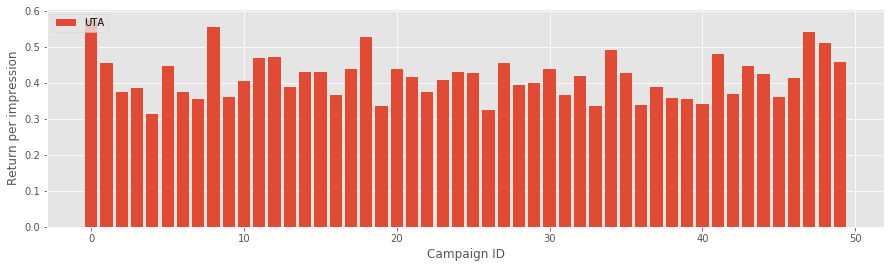

In [90]:
campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(uta[campaign_idx])), uta[campaign_idx], label='UTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Time Decay Attribution

In [91]:
def timrdecay_attribution(df):
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    campaign_impressions = count_by_campaign(df)
    
    
    df_converted = df[df['conversion'] == 1]
    temp_jid=0
    campaign_conversions_nrml=0
    campaign_conversions_first=0
    campaign_conversions_last=0
    campaign_conversions_intermediate=0
    for jid in df_converted.jid.unique():
        if jid != temp_jid:
            temp_jid = jid
            print(temp_jid)
            if df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].max() == df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].min():
                idx_nrml = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
                print("Only 1 Record ")
                campaign_conversions_nrml = count_by_campaign(df_converted[idx_nrml])
            if df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].max() != df_converted[df_converted['jid'] == temp_jid]['timestamp_norm'].min():
                idx_min = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
                idx_max = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
                print("Multiple Records ")
                campaign_conversions_first = count_by_campaign(df_converted[idx_min])
                campaign_conversions_last = count_by_campaign(df_converted[idx_max])
                campaign_conversions_intermediate = (campaign_impressions - (campaign_conversions_first + campaign_conversions_last ))

    return (campaign_conversions_nrml + (campaign_conversions_first * 0.1) + (campaign_conversions_last  * 0.7) + (campaign_conversions_intermediate * 0.2)) / campaign_impressions
tdta = timrdecay_attribution(df6)

23219147_12094942
Multiple Records 
21801985_11191759
Multiple Records 
6084248_12248600
Multiple Records 
26432465_24174905
Multiple Records 
10981333_30499124
Multiple Records 
29823239_4225593
Multiple Records 
13247849_28950214
Multiple Records 
27296207_18389752
Multiple Records 
30123576_5316574
Multiple Records 
9705860_17078307
Multiple Records 
12914345_6457833
Multiple Records 
19508815_5942214
Multiple Records 
18469039_27233042
Multiple Records 
16320332_10606235
Multiple Records 
26101272_15537854
Multiple Records 
26976522_24156292
Multiple Records 
10348329_21265291
Multiple Records 
5045314_3852287
Multiple Records 
14664263_21705276
Multiple Records 
18584071_3122941
Multiple Records 
4534765_10831774
Multiple Records 
23446997_10506951
Multiple Records 
5609745_15764465
Multiple Records 
26084023_23147577
Multiple Records 
25716544_12545589
Multiple Records 
8980279_31869210
Multiple Records 
23802254_31655752
Multiple Records 
4601969_6228830
Multiple Records 
297946

20390236_14644826
Multiple Records 
22478271_1089295
Multiple Records 
10244641_22252552
Multiple Records 
5951360_7854915
Multiple Records 
5460858_6502600
Multiple Records 
13295535_12953239
Multiple Records 
23253182_2576369
Multiple Records 
11487377_27130473
Multiple Records 
24475496_23529407
Multiple Records 
19943798_13680441
Multiple Records 
2886149_18781527
Multiple Records 
10791584_576688
Multiple Records 
15700276_15920696
Multiple Records 
12561644_19556501
Multiple Records 
5069106_17339266
Multiple Records 
29574906_24856414
Multiple Records 
1960004_20350139
Multiple Records 
16854265_31683074
Multiple Records 
3985930_27994686
Multiple Records 
29176813_28929697
Multiple Records 
23313320_25645842
Multiple Records 
15808539_26817601
Multiple Records 
13881323_30015963
Multiple Records 
16750257_11993913
Multiple Records 
9346806_2419092
Multiple Records 
25059946_22954732
Multiple Records 
8661768_27356010
Multiple Records 
27074986_27978723
Multiple Records 
1745971

Multiple Records 
30487070_1135150
Multiple Records 
30953083_7803862
Multiple Records 
29271567_7004069
Multiple Records 
18272916_16640145
Multiple Records 
31810609_2988868
Multiple Records 
6781526_11172298
Multiple Records 
11318849_31271102
Multiple Records 
11532108_25982267
Multiple Records 
31704781_7397058
Multiple Records 
25873573_28009714
Multiple Records 
24419700_25240570
Multiple Records 
10402866_23586912
Multiple Records 
13841837_11207093
Multiple Records 
1570982_25008268
Multiple Records 
11377373_28096362
Multiple Records 
7114376_5804927
Multiple Records 
19180404_2619933
Multiple Records 
5639698_30725916
Multiple Records 
19720594_20761750
Multiple Records 
9403662_31351866
Multiple Records 
11139696_22052573
Multiple Records 
9102464_32306046
Multiple Records 
16491411_18069208
Multiple Records 
4607983_26798659
Multiple Records 
9511139_2416461
Multiple Records 
23985824_25252585
Multiple Records 
25604146_19971632
Multiple Records 
28988083_15771256
Multiple

29005634_17357510
Multiple Records 
1246864_12893778
Multiple Records 
11309142_16796467
Multiple Records 
207713_7051964
Multiple Records 
20952993_22382285
Multiple Records 
6457290_9355798
Multiple Records 
14126704_19920107
Multiple Records 
31669550_32382310
Multiple Records 
10561485_7549849
Multiple Records 
1286592_31913993
Multiple Records 
4222051_21684456
Multiple Records 
114260_18056384
Multiple Records 
7964738_32044404
Multiple Records 
19541801_74383
Multiple Records 
20996209_3940578
Multiple Records 
4442579_9374459
Multiple Records 
23525185_31195762
Multiple Records 
10530173_8000466
Multiple Records 
23598395_20762641
Multiple Records 
3067073_5791458
Multiple Records 
3727507_13425027
Multiple Records 
156368_4389365
Multiple Records 
7938866_19547832
Multiple Records 
30622948_20881321
Multiple Records 
1420825_30384195
Multiple Records 
2627097_17468672
Multiple Records 
10684705_19648446
Multiple Records 
23793621_21679280
Multiple Records 
16673755_19023319
Mu

19386266_20354682
Multiple Records 
27237765_21730637
Multiple Records 
20011036_20528972
Multiple Records 
19572634_25642203
Multiple Records 
14840323_15021128
Multiple Records 
1856690_31578002
Multiple Records 
14350310_19171073
Multiple Records 
16719986_12003913
Multiple Records 
19818277_24146964
Multiple Records 
1132300_4198185
Multiple Records 
4444005_5817720
Multiple Records 
21231928_29524172
Multiple Records 
17203585_1034547
Multiple Records 
7553204_17269251
Multiple Records 
22652768_32063350
Multiple Records 
26654715_10553917
Multiple Records 
11495359_29538224
Multiple Records 
5701896_31926150
Multiple Records 
4579214_30746821
Multiple Records 
19384500_11776369
Multiple Records 
3776421_2253800
Multiple Records 
359790_2167603
Multiple Records 
2496164_19571526
Multiple Records 
27044568_18525884
Multiple Records 
11304983_15515118
Multiple Records 
21801985_2792890
Multiple Records 
30462159_20037685
Multiple Records 
1367372_2148710
Multiple Records 
29704770_9

2565404_28028653
Multiple Records 
3590710_31133867
Multiple Records 
3209455_21096487
Multiple Records 
4132249_8683862
Multiple Records 
18960754_24169173
Multiple Records 
13569818_5460257
Multiple Records 
4220084_30547022
Multiple Records 
23524389_15601893
Multiple Records 
4266217_6795608
Multiple Records 
7257503_3543244
Multiple Records 
1588643_19086820
Multiple Records 
23109803_23591512
Multiple Records 
27531473_19212129
Multiple Records 
14643615_25621614
Multiple Records 
7715183_3869649
Multiple Records 
25834791_14148893
Multiple Records 
6798716_17824037
Multiple Records 
20318072_16856138
Multiple Records 
22559737_23109655
Multiple Records 
12810810_9364310
Multiple Records 
17900646_22440117
Multiple Records 
679807_22644415
Multiple Records 
23799355_4001560
Multiple Records 
15897954_13832035
Multiple Records 
23631148_11713350
Multiple Records 
6489829_9245838
Multiple Records 
30253561_7173958
Multiple Records 
13634242_11348912
Multiple Records 
27838090_25005

Multiple Records 
17621242_2536532
Multiple Records 
25684786_21256368
Multiple Records 
29640421_6046168
Multiple Records 
2109373_22028558
Multiple Records 
24905481_1676662
Multiple Records 
29070868_29123305
Multiple Records 
22084942_10464388
Multiple Records 
24407496_26825581
Multiple Records 
20219195_24130960
Multiple Records 
22478271_8757480
Multiple Records 
25080770_29886888
Multiple Records 
17609493_115741
Multiple Records 
27073986_5689117
Multiple Records 
5290135_9589390
Multiple Records 
6155482_18967202
Multiple Records 
17744348_3437629
Multiple Records 
14555957_3700204
Multiple Records 
142613_3872834
Multiple Records 
18284169_25567389
Multiple Records 
14898237_28435243
Multiple Records 
27950914_5096110
Multiple Records 
21780196_24278643
Multiple Records 
26395313_22552273
Multiple Records 
20492686_6641733
Multiple Records 
24111310_15222219
Multiple Records 
21398301_9688763
Multiple Records 
11317604_26748490
Multiple Records 
17314947_31770791
Multiple Re

13211734_28298395
Multiple Records 
30116551_30604189
Multiple Records 
19775927_24793522
Multiple Records 
31206103_18453485
Multiple Records 
22649131_23818396
Multiple Records 
11601295_8721014
Multiple Records 
12727703_26633133
Multiple Records 
19314567_2091756
Multiple Records 
29506497_26489749
Multiple Records 
15487521_27742982
Multiple Records 
10494954_22639443
Multiple Records 
25192153_3183044
Multiple Records 
2395104_26060159
Multiple Records 
10946467_22769501
Multiple Records 
8762079_21028254
Multiple Records 
1054508_12418275
Multiple Records 
16773357_15335954
Multiple Records 
16535316_16428166
Multiple Records 
12624691_26298537
Multiple Records 
28906699_11996019
Multiple Records 
23218772_24210749
Multiple Records 
24044070_24378696
Multiple Records 
20057405_17698822
Multiple Records 
13703633_13823974
Multiple Records 
17826488_22742836
Multiple Records 
3983089_17473183
Multiple Records 
15589764_5653253
Multiple Records 
10370208_19512405
Multiple Records 


19861763_2954199
Multiple Records 
5223374_10632641
Multiple Records 
15781731_21959028
Multiple Records 
19618971_4052185
Multiple Records 
5841317_24627077
Multiple Records 
18633785_29073990
Multiple Records 
8430062_31682281
Multiple Records 
14762530_18945296
Multiple Records 
30393625_28050215
Multiple Records 
23434951_29526833
Multiple Records 
18345319_21674845
Multiple Records 
10202389_28692531
Multiple Records 
25190980_22131112
Multiple Records 
25172546_28674991
Multiple Records 
9830443_13437677
Multiple Records 
23675033_23078560
Multiple Records 
22061939_1876829
Multiple Records 
17808476_19167824
Multiple Records 
20125547_337096
Multiple Records 
19204249_15297606
Multiple Records 
1316421_4954862
Multiple Records 
8998645_19497280
Multiple Records 
9038551_14860011
Multiple Records 
18583336_14520970
Multiple Records 
4719874_31297386
Multiple Records 
32176974_25341184
Multiple Records 
13372293_11841440
Multiple Records 
9260318_9781285
Multiple Records 
23900115

21494990_23726742
Multiple Records 
7692192_6056333
Multiple Records 
17235101_4415367
Multiple Records 
12967967_2385088
Multiple Records 
25742875_17241476
Multiple Records 
7539747_540718
Multiple Records 
7520836_22455442
Multiple Records 
31069286_30082011
Multiple Records 
4273176_29081322
Multiple Records 
24646235_263667
Multiple Records 
7932590_11897927
Multiple Records 
9996030_5727508
Multiple Records 
29588761_25674984
Multiple Records 
22766407_3401872
Multiple Records 
15820094_7103479
Multiple Records 
30014849_30959909
Multiple Records 
19475638_15002058
Multiple Records 
6012703_13539628
Multiple Records 
10614144_27357267
Multiple Records 
1798691_18638640
Multiple Records 
29986123_9101854
Multiple Records 
20701843_28282707
Multiple Records 
22062416_27769548
Multiple Records 
183137_20035953
Multiple Records 
17447311_511929
Multiple Records 
20100074_18937043
Multiple Records 
23565570_24339815
Multiple Records 
20850501_23761324
Multiple Records 
11231056_138732

Multiple Records 
4935657_31427692
Multiple Records 
5750189_18472133
Multiple Records 
1288443_1438912
Multiple Records 
4520401_6461994
Multiple Records 
5555230_1364991
Multiple Records 
20068129_14000746
Multiple Records 
5554_15935224
Multiple Records 
1999582_13702249
Multiple Records 
2698108_13300519
Multiple Records 
12109237_30616472
Multiple Records 
4702217_25201203
Multiple Records 
1725993_28011537
Multiple Records 
21128617_32414780
Multiple Records 
13455649_25702197
Multiple Records 
17691430_30623698
Multiple Records 
27060256_30448481
Multiple Records 
26670790_18433271
Multiple Records 
2889092_11204384
Multiple Records 
1313076_29397966
Multiple Records 
6700681_5148351
Multiple Records 
11382181_10223128
Multiple Records 
23434951_11207706
Multiple Records 
23521330_20148914
Multiple Records 
7122995_11861016
Multiple Records 
5637791_3026958
Multiple Records 
19940511_21713036
Multiple Records 
3739143_10453516
Multiple Records 
17749137_1457164
Multiple Records 

5317631_16655769
Multiple Records 
32133226_23234681
Multiple Records 
7861041_31027238
Multiple Records 
5529619_31156745
Multiple Records 
5069106_18257586
Multiple Records 
4692891_14390628
Multiple Records 
24878136_30001087
Multiple Records 
2766484_22254006
Multiple Records 
19087809_31897220
Multiple Records 
18860581_14074655
Multiple Records 
2631935_21572969
Multiple Records 
15115787_4249972
Multiple Records 
1780236_922576
Multiple Records 
14697822_30087101
Multiple Records 
20656749_23410960
Multiple Records 
31396938_29256721
Multiple Records 
286123_21535747
Multiple Records 
11297140_124564
Multiple Records 
14792072_24097243
Multiple Records 
23596546_21367087
Multiple Records 
23843884_25966642
Multiple Records 
10301742_16786071
Multiple Records 
17252722_12620081
Multiple Records 
500952_22004396
Multiple Records 
5699648_31003362
Multiple Records 
23233378_13344548
Multiple Records 
18068233_4617350
Multiple Records 
12711798_16946317
Multiple Records 
6668500_290

Multiple Records 
9795583_5604070
Multiple Records 
20800621_18495397
Multiple Records 
10018020_17426035
Multiple Records 
11290465_27025695
Multiple Records 
30847064_10088974
Multiple Records 
22622740_20301785
Multiple Records 
225540_682985
Multiple Records 
25701078_10384481
Multiple Records 
18070111_16123587
Multiple Records 
29606742_7222883
Multiple Records 
18361978_30494989
Multiple Records 
9720454_24325083
Multiple Records 
19737261_9633732
Multiple Records 
22566660_14061415
Multiple Records 
10149871_27912768
Multiple Records 
26083833_6414422
Multiple Records 
27662363_17282093
Multiple Records 
30154956_4862517
Multiple Records 
27907555_31992574
Multiple Records 
15574393_26631559
Multiple Records 
19894747_9839060
Multiple Records 
25987065_28432636
Multiple Records 
1577203_9460078
Multiple Records 
19692647_2127216
Multiple Records 
1331235_30726961
Multiple Records 
8956677_9317236
Multiple Records 
23707757_6951051
Multiple Records 
31871196_26976627
Multiple Re

19219404_610343
Multiple Records 
26353123_20598573
Multiple Records 
18372826_9633893
Multiple Records 
3892838_15506363
Multiple Records 
31730268_29478451
Multiple Records 
17055524_7475168
Multiple Records 
19039628_20529033
Multiple Records 
17707829_30501691
Multiple Records 
19884369_30919160
Multiple Records 
16442726_10808667
Multiple Records 
10322613_31062918
Multiple Records 
10219207_7624950
Multiple Records 
145437_30140870
Multiple Records 
30465069_17803025
Multiple Records 
21955591_16934634
Multiple Records 
12406460_18519792
Multiple Records 
7854376_6924125
Multiple Records 
29702862_16553522
Multiple Records 
4286900_22534743
Multiple Records 
5623468_11849542
Multiple Records 
8661050_11322032
Multiple Records 
12855105_22348219
Multiple Records 
16375190_2640538
Multiple Records 
13140925_26424056
Multiple Records 
12514860_3775692
Multiple Records 
27984523_27223587
Multiple Records 
1040136_32065902
Multiple Records 
11675658_21594607
Multiple Records 
8755455_

14875463_21459925
Multiple Records 
2609983_5640616
Multiple Records 
18798558_11052475
Multiple Records 
10250734_21611909
Multiple Records 
2748635_19498588
Multiple Records 
10449876_2917688
Multiple Records 
6179492_2916999
Multiple Records 
8444627_31684698
Multiple Records 
6395312_9962789
Multiple Records 
31917311_24975406
Multiple Records 
13006443_25286147
Multiple Records 
25382143_191999
Multiple Records 
26737869_11148858
Multiple Records 
23140076_26314874
Multiple Records 
7904368_1503806
Multiple Records 
16815603_4789780
Multiple Records 
29542997_21003340
Multiple Records 
6026446_24143618
Multiple Records 
17203881_27452816
Multiple Records 
6242966_8278889
Multiple Records 
17270741_19053230
Multiple Records 
4510360_20485633
Multiple Records 
8290065_26723553
Multiple Records 
1008435_28949372
Multiple Records 
24740773_18100319
Multiple Records 
29972996_4530155
Multiple Records 
11640707_13140517
Multiple Records 
29169405_1113789
Multiple Records 
32239462_21531

17502917_21450954
Multiple Records 
17938837_10618552
Multiple Records 
6626667_16403993
Multiple Records 
9512697_14219556
Multiple Records 
12727175_9575679
Multiple Records 
14191234_9831928
Multiple Records 
25952209_22888356
Multiple Records 
9718664_2137492
Multiple Records 
3516905_17563079
Multiple Records 
29223411_6813986
Multiple Records 
9695802_19341186
Multiple Records 
76000_27159781
Multiple Records 
27459843_15606901
Multiple Records 
23505627_31538691
Multiple Records 
15754222_14331706
Multiple Records 
32339479_725127
Multiple Records 
2547093_15719937
Multiple Records 
30868712_7422585
Multiple Records 
24862429_31106251
Multiple Records 
5070696_20209258
Multiple Records 
6247231_11030207
Multiple Records 
26884209_1226617
Multiple Records 
13949964_17066465
Multiple Records 
26322915_12258053
Multiple Records 
353323_18441302
Multiple Records 
1842129_21019049
Multiple Records 
3981981_3861663
Multiple Records 
20204786_19293208
Multiple Records 
7277682_19979479

24745063_31971492
Multiple Records 
10926673_20603734
Multiple Records 
16451220_5475265
Multiple Records 
15163858_30987476
Multiple Records 
13651603_2631964
Multiple Records 
16264974_2364651
Multiple Records 
2815084_27004107
Multiple Records 
23819379_5568080
Multiple Records 
8391037_23773377
Multiple Records 
8537023_7371842
Multiple Records 
15163858_242192
Multiple Records 
2949279_24343876
Multiple Records 
2450141_26065428
Multiple Records 
28342654_24042441
Multiple Records 
28003048_5992697
Multiple Records 
4406658_134688
Multiple Records 
28239357_4086230
Multiple Records 
7450896_6134077
Multiple Records 
31317415_21132359
Multiple Records 
22529453_9134826
Multiple Records 
5427535_2557348
Multiple Records 
19274866_22908495
Multiple Records 
9704784_27939885
Multiple Records 
21747893_31029552
Multiple Records 
5516685_8334874
Multiple Records 
5140237_6074150
Multiple Records 
1532210_29779997
Multiple Records 
6554313_15224900
Multiple Records 
3892838_31914897
Mult

Multiple Records 
24370767_5931605
Multiple Records 
31998716_27884143
Multiple Records 
32350114_24167616
Multiple Records 
10369678_19383195
Multiple Records 
2450235_10709474
Multiple Records 
29721614_19021744
Multiple Records 
12332152_7794551
Multiple Records 
17624855_11336233
Multiple Records 
17918801_7641147
Multiple Records 
9490353_12109042
Multiple Records 
21780196_12287153
Multiple Records 
21919361_26376640
Multiple Records 
29736364_8003787
Multiple Records 
12041450_14659934
Multiple Records 
11472904_23861365
Multiple Records 
23934585_13571589
Multiple Records 
4186114_6037175
Multiple Records 
5574719_18616154
Multiple Records 
13949698_22357379
Multiple Records 
12998367_26240378
Multiple Records 
17635949_1672142
Multiple Records 
5224379_5770415
Multiple Records 
16910799_7178278
Multiple Records 
30503102_30682617
Multiple Records 
6814511_15276390
Multiple Records 
26772840_16252276
Multiple Records 
23446997_20174759
Multiple Records 
1256559_31611937
Multipl

Multiple Records 
9668851_12332809
Multiple Records 
26719982_15713336
Multiple Records 
1897212_13176673
Multiple Records 
30426872_32273360
Multiple Records 
17776626_723110
Multiple Records 
12394600_8793692
Multiple Records 
2957354_15546135
Multiple Records 
20433293_32188627
Multiple Records 
22767728_17997563
Multiple Records 
28325403_32407280
Multiple Records 
18269505_20893584
Multiple Records 
30337596_19718189
Multiple Records 
23342847_26915304
Multiple Records 
4923736_24196909
Multiple Records 
7174133_29370993
Multiple Records 
1804978_4223738
Multiple Records 
9590323_27850505
Multiple Records 
29381399_23440723
Multiple Records 
13020014_16569974
Multiple Records 
2049202_18783999
Multiple Records 
12847211_30184505
Multiple Records 
7342857_6960470
Multiple Records 
24688129_21292754
Multiple Records 
20268497_6109702
Multiple Records 
3169356_21849942
Multiple Records 
10106459_27288746
Multiple Records 
6454157_22473115
Multiple Records 
13936314_2843527
Multiple R

Multiple Records 
11098204_19953910
Multiple Records 
7353744_21967849
Multiple Records 
5119247_23616975
Multiple Records 
7688575_10296951
Multiple Records 
9884141_2320805
Multiple Records 
12561459_21254699
Multiple Records 
6117638_30719885
Multiple Records 
676637_13140917
Multiple Records 
30522868_4388947
Multiple Records 
3333255_7307684
Multiple Records 
23069815_9325324
Multiple Records 
17827906_4341145
Multiple Records 
25067692_26998581
Multiple Records 
16153380_29472283
Multiple Records 
25912310_745341
Multiple Records 
14146489_8669713
Multiple Records 
24148066_15688439
Multiple Records 
24702057_25239114
Multiple Records 
14323845_9227389
Multiple Records 
3326082_2512857
Multiple Records 
19128428_10990180
Multiple Records 
10193206_17785158
Multiple Records 
18567284_25114400
Multiple Records 
21579236_15162828
Multiple Records 
22938946_8157669
Multiple Records 
27358842_13651576
Multiple Records 
27573159_27119200
Multiple Records 
5718944_12954279
Multiple Reco

15863128_27201404
Multiple Records 
13959193_8500725
Multiple Records 
2947480_20520869
Multiple Records 
132322_23393850
Multiple Records 
7819177_22641088
Multiple Records 
27531473_14743143
Multiple Records 
6345077_12742843
Multiple Records 
10590760_26977898
Multiple Records 
25705329_22709628
Multiple Records 
1870717_17363692
Multiple Records 
13211734_1383763
Multiple Records 
17861700_17914704
Multiple Records 
24333515_7527295
Multiple Records 
3423961_1895749
Multiple Records 
15279738_27089235
Multiple Records 
30839923_3011384
Multiple Records 
29391680_1044980
Multiple Records 
30966599_25087145
Multiple Records 
8570648_17285467
Multiple Records 
6517317_9904172
Multiple Records 
18971899_31133626
Multiple Records 
22635229_12351425
Multiple Records 
12499382_32275716
Multiple Records 
14959516_29834155
Multiple Records 
10096951_412599
Multiple Records 
3720203_13786961
Multiple Records 
4021401_2846442
Multiple Records 
25634198_7374252
Multiple Records 
12392135_13847

Multiple Records 
8269686_25722816
Multiple Records 
8756022_6556768
Multiple Records 
7848910_17216872
Multiple Records 
13932010_14670674
Multiple Records 
17785543_22379249
Multiple Records 
10178518_31957720
Multiple Records 
8527494_18936076
Multiple Records 
32442952_16781453
Multiple Records 
26530548_23165643
Multiple Records 
20663946_19407103
Multiple Records 
29884441_15334447
Multiple Records 
30628760_17072449
Multiple Records 
31858497_7394584
Multiple Records 
1289602_20876152
Multiple Records 
13196252_12817848
Multiple Records 
6399054_30325688
Multiple Records 
15711577_30321514
Multiple Records 
20123836_13068976
Multiple Records 
21199429_7489622
Multiple Records 
23141357_31191455
Multiple Records 
20173338_25662955
Multiple Records 
20300454_15781421
Multiple Records 
20648976_29228490
Multiple Records 
3941243_6050110
Multiple Records 
30893455_14078234
Multiple Records 
23496483_4093140
Multiple Records 
30921239_28371637
Multiple Records 
7174931_3469985
Multip

23380390_6045738
Multiple Records 
18044671_20324281
Multiple Records 
5025733_20416154
Multiple Records 
8755343_32011959
Multiple Records 
1938619_18515563
Multiple Records 
9547388_30097953
Multiple Records 
9824339_23532111
Multiple Records 
24021660_24871310
Multiple Records 
17060628_23342806
Multiple Records 
20930176_16757195
Multiple Records 
6598396_32336141
Multiple Records 
11224941_14836536
Multiple Records 
16221915_5861640
Multiple Records 
29835168_8845085
Multiple Records 
12187746_21077480
Multiple Records 
3221760_2395325
Multiple Records 
3393873_13599671
Multiple Records 
26208917_20365857
Multiple Records 
32321163_22020929
Multiple Records 
27942136_18920503
Multiple Records 
6280564_1425884
Multiple Records 
24042373_27421732
Multiple Records 
19584672_32229525
Multiple Records 
5168463_25814804
Multiple Records 
24476142_26267548
Multiple Records 
23531974_29367410
Multiple Records 
22525971_3658062
Multiple Records 
16657590_25418601
Multiple Records 
18364916

Multiple Records 
11012651_19944235
Multiple Records 
30300409_31990820
Multiple Records 
21758248_17457559
Multiple Records 
17178948_11586962
Multiple Records 
3232699_6474631
Multiple Records 
9769673_24532333
Multiple Records 
28584874_26914321
Multiple Records 
18272725_2088608
Multiple Records 
29506534_18882300
Multiple Records 
3078151_20471645
Multiple Records 
19688311_16684540
Multiple Records 
26404391_28399955
Multiple Records 
8805799_26521342
Multiple Records 
27052471_11681024
Multiple Records 
7716635_14252456
Multiple Records 
4070093_12467261
Multiple Records 
19943794_19457535
Multiple Records 
5453639_132676
Multiple Records 
1912501_9348385
Multiple Records 
5699356_19402236
Multiple Records 
6891678_17071672
Multiple Records 
30361142_29072691
Multiple Records 
6870328_21236736
Multiple Records 
10646658_14991886
Multiple Records 
12298615_24961613
Multiple Records 
6810902_19188889
Multiple Records 
10859933_31507825
Multiple Records 
22131189_8840843
Multiple R

Multiple Records 
20591554_28739268
Multiple Records 
22954649_9800350
Multiple Records 
28610567_361863
Multiple Records 
6225840_2719257
Multiple Records 
20975002_20507135
Multiple Records 
1109009_25442566
Multiple Records 
1656934_20039264
Multiple Records 
24352283_2700610
Multiple Records 
5983053_15338468
Multiple Records 
24812932_22265922
Multiple Records 
351747_8099568
Multiple Records 
14057000_18635631
Multiple Records 
30189394_13747232
Multiple Records 
8498787_16585954
Multiple Records 
22963345_1014733
Multiple Records 
3899893_5960501
Multiple Records 
25106011_3002038
Multiple Records 
25981400_15258696
Multiple Records 
23156199_24052123
Multiple Records 
7952423_12256682
Multiple Records 
20019831_26585184
Multiple Records 
20967305_9232060
Multiple Records 
10810391_22193865
Multiple Records 
7913094_19764079
Multiple Records 
11877674_2670484
Multiple Records 
13454368_20138231
Multiple Records 
14896452_11193254
Multiple Records 
16967197_6615040
Multiple Recor

Multiple Records 
21705297_19635387
Multiple Records 
1082212_16268014
Multiple Records 
20007348_9973061
Multiple Records 
29708690_539422
Multiple Records 
31486809_8716685
Multiple Records 
30945571_15110690
Multiple Records 
4552508_4026139
Multiple Records 
1073493_15416162
Multiple Records 
5351210_2888754
Multiple Records 
17362866_31848667
Multiple Records 
21836907_16435235
Multiple Records 
7736710_16872044
Multiple Records 
484762_12669290
Multiple Records 
4272318_16685097
Multiple Records 
28653783_11900674
Multiple Records 
2423824_11720519
Multiple Records 
22755616_10110437
Multiple Records 
19509140_4039377
Multiple Records 
20211331_29768690
Multiple Records 
15461650_22776346
Multiple Records 
30441969_3881047
Multiple Records 
25877900_6474961
Multiple Records 
14265575_11451537
Multiple Records 
11355276_26332587
Multiple Records 
4821108_1389114
Multiple Records 
9345104_12609193
Multiple Records 
8732587_30222758
Multiple Records 
11527912_29537638
Multiple Recor

Multiple Records 
9747010_12912432
Multiple Records 
12410647_10851726
Multiple Records 
4192984_29802291
Multiple Records 
10150947_6541519
Multiple Records 
23345266_7558723
Multiple Records 
7237211_4045559
Multiple Records 
1190258_18475225
Multiple Records 
3240960_17256202
Multiple Records 
2113793_16238036
Multiple Records 
3973601_13761102
Multiple Records 
16933887_15212871
Multiple Records 
21995623_6899716
Multiple Records 
19463123_27227799
Multiple Records 
2196835_17812342
Multiple Records 
9690764_26136216
Multiple Records 
3288560_9745237
Multiple Records 
29481564_14242262
Multiple Records 
24761539_3738067
Multiple Records 
9434362_20537638
Multiple Records 
9502692_18327023
Multiple Records 
13797770_12054501
Multiple Records 
5671692_23562254
Multiple Records 
10178922_12753823
Multiple Records 
20049128_1713722
Multiple Records 
12991136_5433336
Multiple Records 
16221205_20937334
Multiple Records 
28584874_3616903
Multiple Records 
17908616_16137847
Multiple Recor

14798523_3897442
Multiple Records 
25424122_24799915
Multiple Records 
10063041_372474
Multiple Records 
31569601_30835439
Multiple Records 
24846795_4820804
Multiple Records 
1952663_31892733
Multiple Records 
8696351_75308
Multiple Records 
30726289_26239727
Multiple Records 
15754222_32010774
Multiple Records 
18553401_10099813
Multiple Records 
336598_31179934
Multiple Records 
23947902_27982767
Multiple Records 
10735119_4104247
Multiple Records 
15668187_758039
Multiple Records 
4410525_31446062
Multiple Records 
20585997_25429802
Multiple Records 
6258687_27380733
Multiple Records 
26365_10260927
Multiple Records 
29203240_2714191
Multiple Records 
30048982_20275559
Multiple Records 
9709857_25577860
Multiple Records 
5649700_12241796
Multiple Records 
10419277_8811008
Multiple Records 
21633715_13545783
Multiple Records 
21599336_10977335
Multiple Records 
25275521_30979757
Multiple Records 
7731803_26808435
Multiple Records 
31006192_27183938
Multiple Records 
13169687_9798075

9602265_11397382
Multiple Records 
4042786_20801850
Multiple Records 
19706014_17602937
Multiple Records 
11988567_16613019
Multiple Records 
7709331_7618383
Multiple Records 
16818867_9043534
Multiple Records 
1720772_9996629
Multiple Records 
8629011_29133829
Multiple Records 
7370763_23665314
Multiple Records 
10590811_9974257
Multiple Records 
19861763_5716498
Multiple Records 
19335146_3624702
Multiple Records 
2846638_23146198
Multiple Records 
7854859_31977681
Multiple Records 
32025253_488679
Multiple Records 
9968201_8725736
Multiple Records 
3274908_17230059
Multiple Records 
30444319_18018286
Multiple Records 
10168403_19263649
Multiple Records 
2180816_21226639
Multiple Records 
28383525_22006623
Multiple Records 
6316221_8906032
Multiple Records 
14512181_3055455
Multiple Records 
27359221_8884815
Multiple Records 
32223874_7973219
Multiple Records 
4292472_29732273
Multiple Records 
11847997_6754041
Multiple Records 
18828038_31395955
Multiple Records 
26700639_30552691
M

8046050_25604352
Multiple Records 
6995324_17185613
Multiple Records 
19553804_26530940
Multiple Records 
29734646_22441759
Multiple Records 
26850468_16939846
Multiple Records 
14840323_18427237
Multiple Records 
17619750_22663663
Multiple Records 
14294365_30110355
Multiple Records 
28790018_8509922
Multiple Records 
17941371_1979191
Multiple Records 
13044093_14377507
Multiple Records 
10188212_4965367
Multiple Records 
2656520_19952037
Multiple Records 
18634246_11018240
Multiple Records 
5662870_6615631
Multiple Records 
8649396_7860790
Multiple Records 
21273233_5785751
Multiple Records 
30809508_15560145
Multiple Records 
14208576_11107154
Multiple Records 
25197257_10631426
Multiple Records 
31714354_32288271
Multiple Records 
8073450_20863307
Multiple Records 
2957008_30684967
Multiple Records 
19363691_9151454
Multiple Records 
28669515_13542552
Multiple Records 
145437_19144192
Multiple Records 
31725437_29085197
Multiple Records 
11938283_11538680
Multiple Records 
10718233

Multiple Records 
5590863_24583671
Multiple Records 
24473347_12232391
Multiple Records 
16820785_1183579
Multiple Records 
9628700_23400837
Multiple Records 
6478505_27841497
Multiple Records 
13525868_16408107
Multiple Records 
14335635_15007097
Multiple Records 
27897827_7601846
Multiple Records 
15464631_20369342
Multiple Records 
19329715_27153009
Multiple Records 
6939320_31711997
Multiple Records 
19848533_21917019
Multiple Records 
2427477_10864585
Multiple Records 
21578484_31143435
Multiple Records 
20237329_6886909
Multiple Records 
22476514_22215962
Multiple Records 
20075585_27688792
Multiple Records 
15937456_6138060
Multiple Records 
2914190_16311187
Multiple Records 
16615253_20732063
Multiple Records 
17613614_9737243
Multiple Records 
5055319_2935403
Multiple Records 
14085040_22665671
Multiple Records 
24371423_27237472
Multiple Records 
8792859_31038999
Multiple Records 
14732908_11303981
Multiple Records 
2792983_25818045
Multiple Records 
5827296_24344399
Multiple

Multiple Records 
21784443_10751390
Multiple Records 
17115483_14241370
Multiple Records 
28866151_4861911
Multiple Records 
25067692_27415790
Multiple Records 
15367590_17972590
Multiple Records 
5211914_600278
Multiple Records 
17977435_3353256
Multiple Records 
22396664_23815248
Multiple Records 
13977173_8291969
Multiple Records 
3396842_16876790
Multiple Records 
14752762_28390307
Multiple Records 
7208008_22072226
Multiple Records 
12054548_23063668
Multiple Records 
29821066_21952688
Multiple Records 
28127495_30535936
Multiple Records 
1572244_1109274
Multiple Records 
26262147_26108281
Multiple Records 
24941698_24320823
Multiple Records 
31859021_18597155
Multiple Records 
30663982_2728650
Multiple Records 
9885730_26128783
Multiple Records 
27262982_27284859
Multiple Records 
22480567_23438172
Multiple Records 
28279319_954921
Multiple Records 
19196504_19352017
Multiple Records 
8843705_5250446
Multiple Records 
1998744_2031870
Multiple Records 
19043167_10683862
Multiple R

2293265_23830023
Multiple Records 
14500628_29662407
Multiple Records 
10590811_8535620
Multiple Records 
25438596_7063460
Multiple Records 
244240_22043398
Multiple Records 
11044177_21830929
Multiple Records 
22899006_23454248
Multiple Records 
23529631_22866595
Multiple Records 
26254715_13731833
Multiple Records 
18481714_2531660
Multiple Records 
1712453_27927600
Multiple Records 
16859127_19121273
Multiple Records 
13651603_13161025
Multiple Records 
10329864_7487902
Multiple Records 
10278423_5824810
Multiple Records 
24840047_26022901
Multiple Records 
18198143_18958411
Multiple Records 
8661325_10128286
Multiple Records 
735035_4256021
Multiple Records 
19251099_16258553
Multiple Records 
9171835_20797653
Multiple Records 
11480099_15113958
Multiple Records 
25384317_27014254
Multiple Records 
6929787_27274839
Multiple Records 
26675181_17930021
Multiple Records 
2274425_28812158
Multiple Records 
28004921_29523983
Multiple Records 
11217014_28901318
Multiple Records 
25818545

23337435_31017865
Multiple Records 
19704777_9370643
Multiple Records 
17145560_19400990
Multiple Records 
1538881_10000254
Multiple Records 
13478708_17344809
Multiple Records 
13121106_16749404
Multiple Records 
7041135_1026163
Multiple Records 
8472964_30310659
Multiple Records 
17512519_15462679
Multiple Records 
18192616_898258
Multiple Records 
27306913_32013997
Multiple Records 
22162674_17012245
Multiple Records 
27011837_23751104
Multiple Records 
30520458_5162464
Multiple Records 
16331326_8602223
Multiple Records 
20136857_21377306
Multiple Records 
20539787_3528966
Multiple Records 
16116267_17156331
Multiple Records 
10533655_27675623
Multiple Records 
17118548_17334269
Multiple Records 
3203913_7479187
Multiple Records 
25574075_677709
Multiple Records 
15374078_18050828
Multiple Records 
13775274_13793921
Multiple Records 
351747_22255405
Multiple Records 
23135563_21071956
Multiple Records 
23792747_27522370
Multiple Records 
6109268_12218363
Multiple Records 
10835232_

28376259_15968143
Multiple Records 
20360603_14519149
Multiple Records 
9227227_939396
Multiple Records 
32448176_17186312
Multiple Records 
6883390_1899332
Multiple Records 
27283294_27162197
Multiple Records 
26630185_25882229
Multiple Records 
21584816_7789584
Multiple Records 
15965018_23672408
Multiple Records 
16793955_12251186
Multiple Records 
28930564_7103739
Multiple Records 
8212078_12459192
Multiple Records 
10779165_32458060
Multiple Records 
22655676_7967498
Multiple Records 
2672727_7408814
Multiple Records 
7261649_20403779
Multiple Records 
6123218_8857563
Multiple Records 
4937308_13028670
Multiple Records 
15927445_27391250
Multiple Records 
6126067_11046653
Multiple Records 
19720400_20226028
Multiple Records 
23567106_2384848
Multiple Records 
30165937_25132898
Multiple Records 
20232664_11294838
Multiple Records 
26199801_17964367
Multiple Records 
10819951_31364260
Multiple Records 
11678229_20419295
Multiple Records 
20372609_28316172
Multiple Records 
28596204_

25888213_32334794
Multiple Records 
17762962_23628894
Multiple Records 
3982238_1912152
Multiple Records 
12450082_23203241
Multiple Records 
17848788_19634593
Multiple Records 
28910521_2962567
Multiple Records 
6406059_24615549
Multiple Records 
13972726_7785293
Multiple Records 
4192984_24975479
Multiple Records 
5428327_29749011
Multiple Records 
29174018_18709857
Multiple Records 
30370336_17657830
Multiple Records 
28046510_8952036
Multiple Records 
24742345_6036904
Multiple Records 
11927563_20880664
Multiple Records 
15024449_13730704
Multiple Records 
1907099_11300892
Multiple Records 
15986811_27451471
Multiple Records 
24635893_29797094
Multiple Records 
22583770_8933516
Multiple Records 
29797086_14224244
Multiple Records 
10843056_28381211
Multiple Records 
13759126_27133508
Multiple Records 
4895418_360182
Multiple Records 
25740204_22326595
Multiple Records 
26854198_30584450
Multiple Records 
20806648_23561604
Multiple Records 
20695770_12349404
Multiple Records 
230688

Multiple Records 
7885685_3862192
Multiple Records 
6244350_30987796
Multiple Records 
23101924_21220377
Multiple Records 
20494559_2644918
Multiple Records 
28871209_30069710
Multiple Records 
14249421_14137552
Multiple Records 
1719437_16919026
Multiple Records 
21951064_17388756
Multiple Records 
25799448_14925141
Multiple Records 
1917470_7541221
Multiple Records 
14884187_25038357
Multiple Records 
28697112_5115440
Multiple Records 
29562695_12725738
Multiple Records 
30918812_2428682
Multiple Records 
23219730_527133
Multiple Records 
22500897_28552964
Multiple Records 
1053445_28934604
Multiple Records 
14922392_17197544
Multiple Records 
5691767_22510867
Multiple Records 
30977177_10326090
Multiple Records 
8952963_641299
Multiple Records 
1129398_7484556
Multiple Records 
4012915_9581581
Multiple Records 
4298455_25079579
Multiple Records 
24407496_28549768
Multiple Records 
26491073_21969336
Multiple Records 
6552626_16174203
Multiple Records 
27322489_519218
Multiple Records

Multiple Records 
10163546_15298973
Multiple Records 
15270968_11783508
Multiple Records 
32315902_6718855
Multiple Records 
2820268_20650041
Multiple Records 
7061244_215465
Multiple Records 
20845457_12727799
Multiple Records 
24567575_7259900
Multiple Records 
8034988_20882692
Multiple Records 
12205035_14206967
Multiple Records 
21021045_12669780
Multiple Records 
26592854_8424850
Multiple Records 
26056205_18684656
Multiple Records 
10753201_21231373
Multiple Records 
10132320_17030106
Multiple Records 
22581095_4372335
Multiple Records 
21753728_15189266
Multiple Records 
12422796_5898136
Multiple Records 
17940664_12430933
Multiple Records 
29037086_6065592
Multiple Records 
20049128_16528646
Multiple Records 
5394497_13050219
Multiple Records 
10959206_6188272
Multiple Records 
6591063_26291435
Multiple Records 
28299705_18814666
Multiple Records 
32203430_30019808
Multiple Records 
1594095_28462808
Multiple Records 
4657423_4040265
Multiple Records 
23465532_2532620
Multiple R

4705969_12788127
Multiple Records 
27970870_26847108
Multiple Records 
14003041_3499801
Multiple Records 
21957446_28760998
Multiple Records 
22644849_16577748
Multiple Records 
26467540_3238332
Multiple Records 
28614170_2729978
Multiple Records 
1855837_788174
Multiple Records 
1861265_17325565
Multiple Records 
1643561_1166386
Multiple Records 
31377804_23828037
Multiple Records 
7705343_12757083
Multiple Records 
15858373_16520383
Multiple Records 
26057689_919853
Multiple Records 
22054160_13871603
Multiple Records 
25488616_32289047
Multiple Records 
28963181_18089116
Multiple Records 
12717549_32417890
Multiple Records 
28267716_16510486
Multiple Records 
19900758_4390220
Multiple Records 
16717018_17296597
Multiple Records 
1573176_2118785
Multiple Records 
31293968_6633537
Multiple Records 
1974725_8067431
Multiple Records 
22328306_16275290
Multiple Records 
9823941_31849353
Multiple Records 
7041135_10616810
Multiple Records 
25952209_28167877
Multiple Records 
9079150_24590

Multiple Records 
14785010_3221072
Multiple Records 
29929424_6759492
Multiple Records 
30878851_6106284
Multiple Records 
3389935_14678037
Multiple Records 
14643367_19134860
Multiple Records 
5329685_26909857
Multiple Records 
11153192_18154642
Multiple Records 
16363416_20960285
Multiple Records 
1839301_14286691
Multiple Records 
4431575_1437984
Multiple Records 
15988259_19096785
Multiple Records 
31252537_24229908
Multiple Records 
9516473_31805062
Multiple Records 
14263940_1672575
Multiple Records 
10259551_24399910
Multiple Records 
1951018_6087874
Multiple Records 
3728824_23365303
Multiple Records 
27368446_118016
Multiple Records 
17256091_1902320
Multiple Records 
19514600_2739360
Multiple Records 
23174417_1506147
Multiple Records 
10449614_26173144
Multiple Records 
14046393_4232867
Multiple Records 
13942158_383497
Multiple Records 
12841455_2643504
Multiple Records 
4396046_15070096
Multiple Records 
7688112_21642047
Multiple Records 
26916748_26080358
Multiple Records

12135588_6813604
Multiple Records 
32220627_23895121
Multiple Records 
25143344_6321522
Multiple Records 
9014907_6219045
Multiple Records 
21216432_8367422
Multiple Records 
16110064_22981654
Multiple Records 
488089_5243822
Multiple Records 
6109871_28574880
Multiple Records 
16241355_4592246
Multiple Records 
3053485_19984384
Multiple Records 
16925528_31831395
Multiple Records 
19200499_4737367
Multiple Records 
27124763_8439520
Multiple Records 
25384317_1408775
Multiple Records 
14806353_1301528
Multiple Records 
20675405_32045732
Multiple Records 
5630942_5018133
Multiple Records 
31293548_5073490
Multiple Records 
10606852_27742567
Multiple Records 
871001_13272366
Multiple Records 
27347195_24587041
Multiple Records 
26696370_15715725
Multiple Records 
375602_13605514
Multiple Records 
19140031_3623650
Multiple Records 
28936568_1580812
Multiple Records 
19506726_549644
Multiple Records 
22551556_13176506
Multiple Records 
25131831_3986150
Multiple Records 
19005187_8215555
Mu

Multiple Records 
19711007_6856169
Multiple Records 
25755636_9427658
Multiple Records 
25032456_16047440
Multiple Records 
24005507_29349593
Multiple Records 
30095781_30888470
Multiple Records 
247369_11318805
Multiple Records 
30068536_15943741
Multiple Records 
11576870_9296129
Multiple Records 
14858669_29709883
Multiple Records 
23524389_520642
Multiple Records 
29154021_13789331
Multiple Records 
17301064_3525206
Multiple Records 
16149656_25485401
Multiple Records 
31481854_10428949
Multiple Records 
7779186_6520739
Multiple Records 
25135443_29226439
Multiple Records 
20116295_24176432
Multiple Records 
5217614_2559996
Multiple Records 
22453314_24437755
Multiple Records 
12824355_16641939
Multiple Records 
26637721_25633617
Multiple Records 
4512425_27764096
Multiple Records 
23384578_32240000
Multiple Records 
3926597_15413879
Multiple Records 
15558352_717584
Multiple Records 
2627283_23668608
Multiple Records 
30705835_8895184
Multiple Records 
3183135_8223122
Multiple Rec

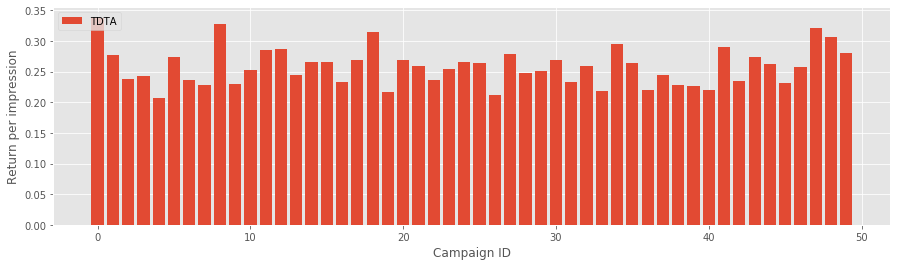

In [92]:
campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(tdta[campaign_idx])), tdta[campaign_idx], label='TDTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Logistic Regression

In [93]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [94]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))

(15629, 349)


In [95]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [96]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8288547664747281


C:\Users\sohai\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [97]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 10002 samples, validate on 2501 samples
Epoch 1/10
10002/10002 [==============================] - 0s 44us/step - loss: 0.6628 - accuracy: 0.6002 - val_loss: 0.6069 - val_accuracy: 0.6897
Epoch 2/10
10002/10002 [==============================] - 0s 13us/step - loss: 0.5915 - accuracy: 0.6906 - val_loss: 0.5580 - val_accuracy: 0.7545
Epoch 3/10
10002/10002 [==============================] - 0s 13us/step - loss: 0.5529 - accuracy: 0.7475 - val_loss: 0.5307 - val_accuracy: 0.7745
Epoch 4/10
10002/10002 [==============================] - 0s 12us/step - loss: 0.5294 - accuracy: 0.7645 - val_loss: 0.5141 - val_accuracy: 0.7797
Epoch 5/10
10002/10002 [==============================] - 0s 17us/step - loss: 0.5143 - accuracy: 0.7763 - val_loss: 0.5034 - val_accuracy: 0.7833
Epoch 6/10
10002/10002 [==============================] - 0s 12us/step - loss: 0.5038 - accuracy: 0.7826 - val_loss: 0.4959 - val_accuracy: 0.7853
Epoch 7/10
10002/10002 [==============================] - 0s 11us/ste

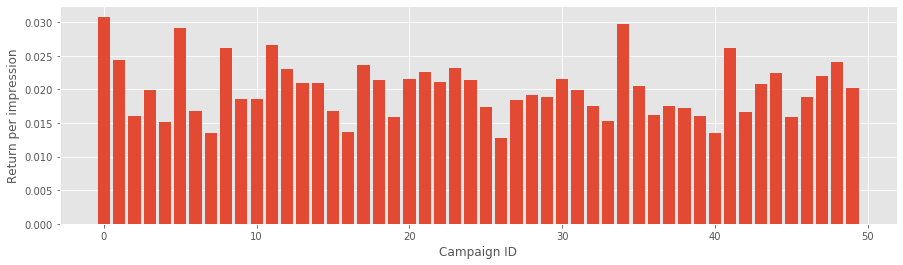

In [98]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

# Simulation

In [103]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])
def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [107]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [fta, lta, lita, uta,tdta, keras_logreg]
for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        print('{} {} : {}'.format(i, j, reward))

0 0 : 376
0 1 : 373
0 2 : 381
0 3 : 381
1 0 : 390
1 1 : 371
1 2 : 377
1 3 : 378
2 0 : 407
2 1 : 387
2 2 : 375
2 3 : 376
3 0 : 473
3 1 : 414
3 2 : 385
3 3 : 386
4 0 : 538
4 1 : 435
4 2 : 394
4 3 : 388
5 0 : 566
5 1 : 446
5 2 : 412
5 3 : 399
6 0 : 603
6 1 : 452
6 2 : 426
6 3 : 411
7 0 : 664
7 1 : 427
7 2 : 448
7 3 : 420


Citation:
Channel Attribution - https://github.com/ikatsov/tensor-house/blob/master/promotions/channel-attribution-lstm.ipynb
Time Decay Attribution - https://www.callrail.com/blog/what-is-time-decay-attribution/
R implementation of Attribution Model - https://github.com/amrrs/adobe_analytics_with_R/tree/4a3b9930a20be00fbb622521d8310de00bcb3c94
Marketing Channel Attribution - https://medium.com/@mortenhegewald/marketing-channel-attribution-using-markov-chains-101-in-python-78fb181ebf1e